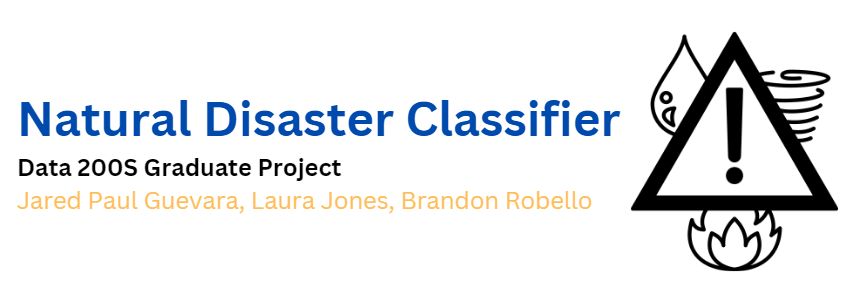


# Loading Data


**Importing the necessary utility functions, required libraries and packages needed for our classifier:**


In [1]:
import json
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

from data_utils import get_images, get_labels 
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.filters import gabor_kernel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

**Loading the dataset from the mounted Google Drive:**


In [2]:
# Create a list containing the three different natural disasters we'll be investigating
disaster_list = ["socal-fire", "midwest-flooding", "hurricane-matthew"]

# Initializing data as a dictionary of dictionaries in {image:label} format
data = {}
split = "train"
config_path = './config.json'

# Loading configuration settings from config.json file
with open(config_path) as config_file:
    config = json.load(config_file)
    data_zip = config['data_zip']
    data_dir = config['data_dir']

# Unzipping the file containing all of the data
with ZipFile(data_zip) as zip_file:
    zip_file.extractall('../data/')

# Loading image and label data from unzipped files
for disaster in disaster_list:
    print(f"Loading {split}ing images and labels from the {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

Loading training images and labels from the socal-fire dataset...
Loading training images and labels from the midwest-flooding dataset...
Loading training images and labels from the hurricane-matthew dataset...


# Exploratory Data Analysis (EDA)


Our principal EDA consists of the following tasks:

1. Calculating basic statistics, such as:

- Number of images per diaster type (via the length of dictionaries)
- Distribution of image heights, widths, and total sizes (via histograms)
- Distribution of damage labels (via bar charts)

2. Exploring insightful image features

- Color intensity distributions of each red, blue, and green channels per disaster (via histograms)

3. Creating the dataframes that contain features for each image

- Two dataframes:
  - `task_1_df` - contains images and features from both `socal-fire` and `midwest-flooding`
  - `task_2_df` - contains images and features from `hurricane-matthew`
- Verifying that our data has no `NaN` values (via df.isna())

4. Visualizing images under different color channels and image processing features (Sobel, LBP, Gabor)
5. Performing `.groupby()` operations on disaster type (Task 1) and label (Task 2) to identify possible features for model

- Mean total pixels and average pixel intensity are considerably higher in the `socal-fire` images set compared to the `midwest-flooding`


**Finding the total number of images per disaster:**

Among all three disasters, `hurricane-matthew` seems to have the largest number of images, which makes sense considering we will most likely need to extract more features and fit our model to correctly classify the damage level. `socal-fire` and `midwest-flooding` will be combined into one dataset, since images from both sets will be used to train the a model to classify the disasters from each other.


In [3]:
# Number of images in Dataset
disaster_list = ["socal-fire", "midwest-flooding", "hurricane-matthew"]
for disaster in disaster_list:
  print(f"There are {len(data[disaster]['images'])} images in the {disaster} dataset.")

There are 8380 images in the socal-fire dataset.
There are 7004 images in the midwest-flooding dataset.
There are 11151 images in the hurricane-matthew dataset.


**Visualizing the distribution of image heights, widths, and total pixel sizes per disaster:**


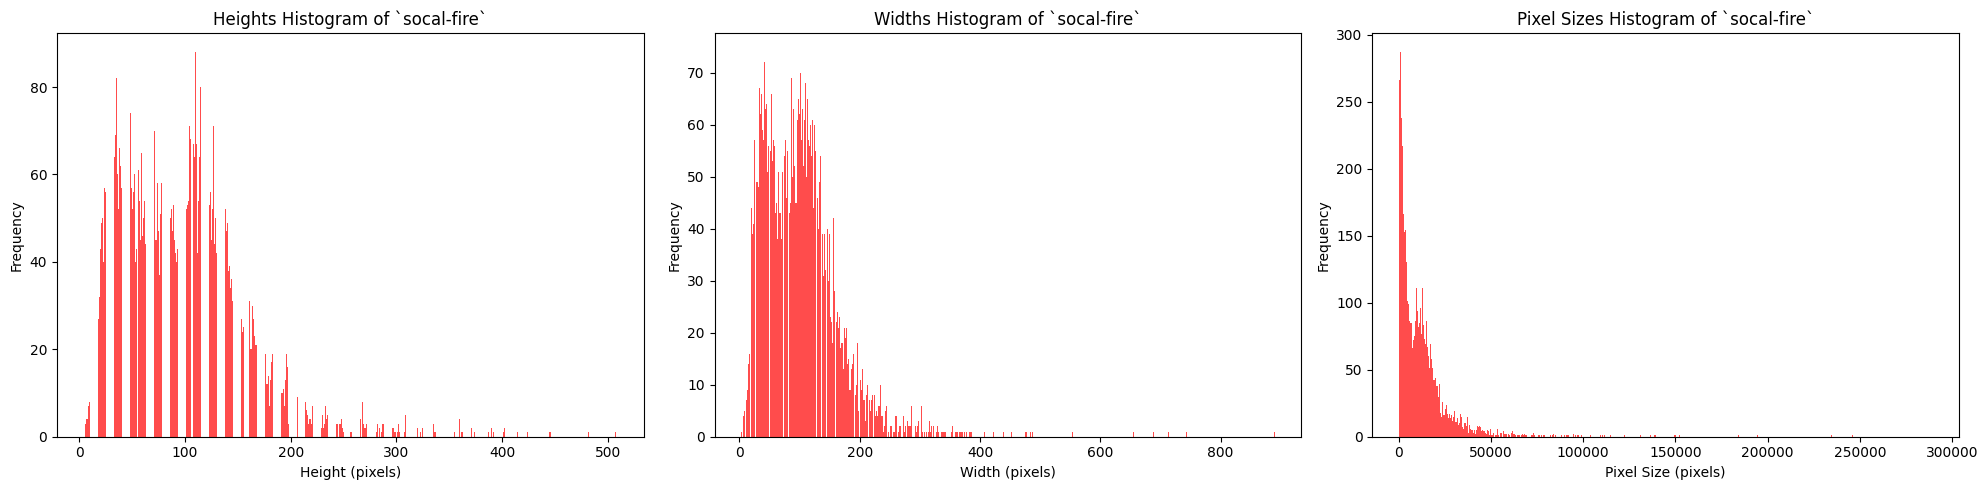

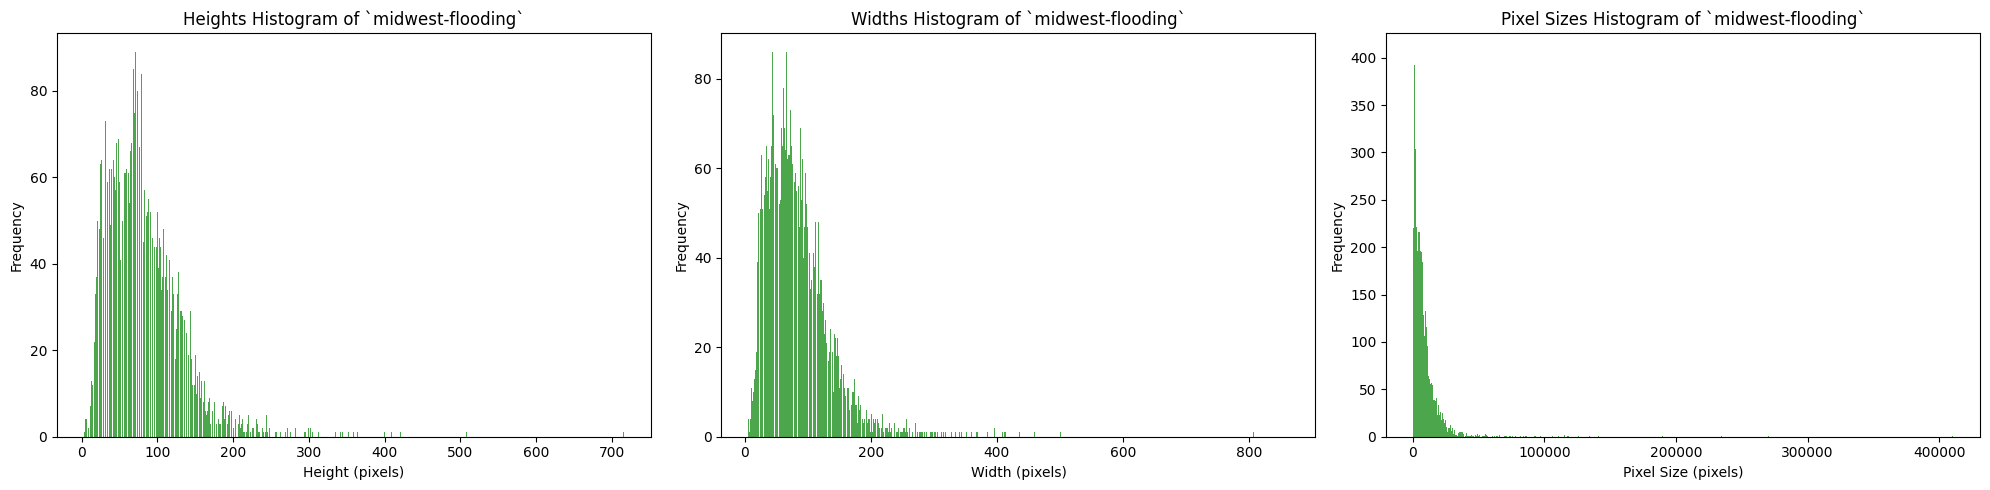

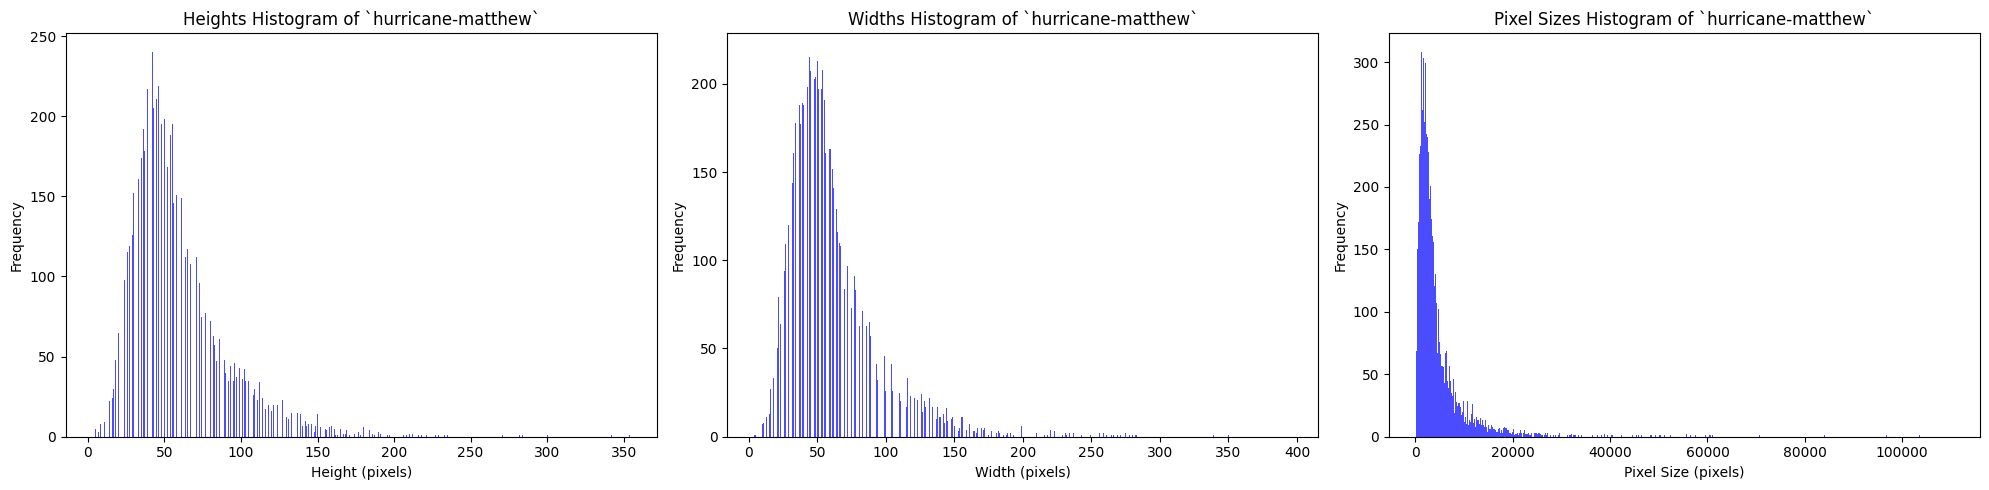

In [4]:
# Get image sizes and plot distribution
color_dict = {"socal-fire": "red", "midwest-flooding":"green", "hurricane-matthew":"blue"}

# Store image attributes in a dictionary of lists
total_pixel_sizes = {}
heights = {}
widths = {}

for disaster in disaster_list:
  total_pixel_sizes[disaster] = []
  heights[disaster] = []
  widths[disaster] = []

  for i in range(len(data[disaster]['images'])):
    image = data[disaster]['images'][i]
    height = image.shape[0]
    width = image.shape[1]
    total_pixel_size = height * width

    total_pixel_sizes[disaster].append(total_pixel_size)
    heights[disaster].append(height)
    widths[disaster].append(width)

  # Print Statements of min and max
  # print(f"{disaster} Height min: {min(Heights[disaster])} & max: {max(Heights[disaster])}")
  # print(f"{disaster} Width min: {min(Widths[disaster])} & max: {max(Widths[disaster])}")
  # print(f"{disaster} TPS min: {min(Total_pixel_sizes[disaster])} & max: {max(Total_pixel_sizes[disaster])}")

  # Create a figure to contain the subplots with a size of 15x10
  plt.figure(figsize=(20, 5))

  # Heights histogram
  plt.subplot(1, 3, 1)  # 1st row, 1st col
  plt.hist(heights[disaster], bins=1000, color=color_dict[disaster], alpha=0.7)
  plt.title(f'Heights Histogram of `{disaster}`')
  plt.xlabel('Height (pixels)')
  plt.ylabel('Frequency')

  # Widths histogram
  plt.subplot(1, 3, 2)  # 2nd row, 1st col
  plt.hist(widths[disaster], bins=1000, color=color_dict[disaster], alpha=0.7)
  plt.title(f'Widths Histogram of `{disaster}`')
  plt.xlabel('Width (pixels)')
  plt.ylabel('Frequency')

  # Total Pixel Sizes histogram
  plt.subplot(1, 3, 3)  # 3rd row, 1st col
  plt.hist(total_pixel_sizes[disaster], bins=1000, color=color_dict[disaster], alpha=0.7)
  plt.title(f'Pixel Sizes Histogram of `{disaster}`')
  plt.xlabel('Pixel Size (pixels)')
  plt.ylabel('Frequency')


  # Adjust the layout
  plt.tight_layout()
  plt.show()

**Visualizng the damage label distributions per disaster:**

Note: Task 1's goal is to differentiate between images from `socal-fire` and `midwest-flooding`. Task 2's goal is to classify the damage level of images from `hurricane-matthew` on a scale of 0 through 3. The difference in goals explains why the distribution of labels is different between all three disasters, with the majority of labels from `socal-fire` and `midwest-flooding` being 0 vs. a more spread out distribution from `hurricane-matthew`.


Value counts for labels in socal-fire:
0    7204
1      69
2      43
3    1064
Name: count, dtype: int64


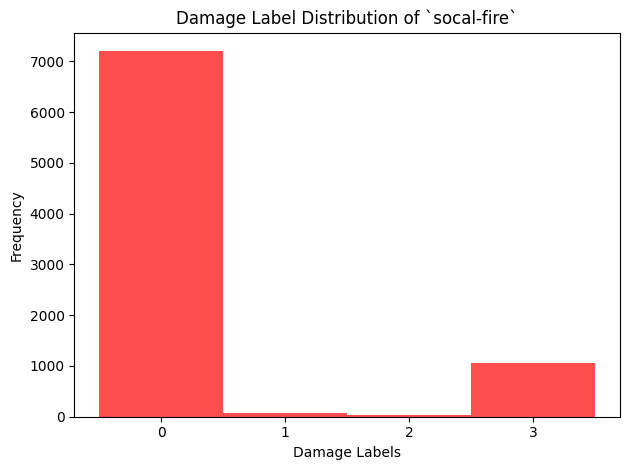

Value counts for labels in midwest-flooding:
0    6734
1     114
2      97
3      59
Name: count, dtype: int64


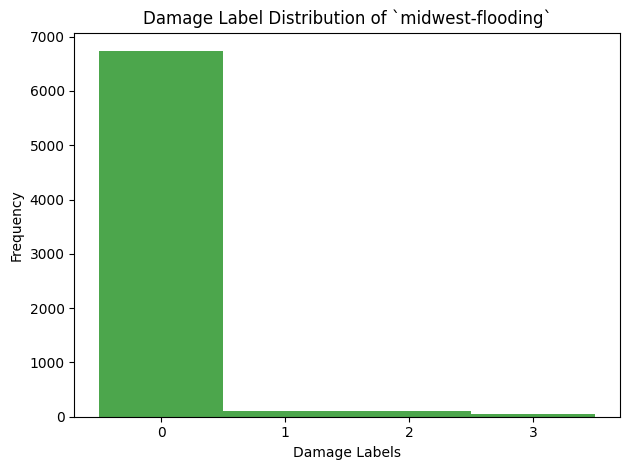

Value counts for labels in hurricane-matthew:
0    2631
1    5236
2    1544
3    1740
Name: count, dtype: int64


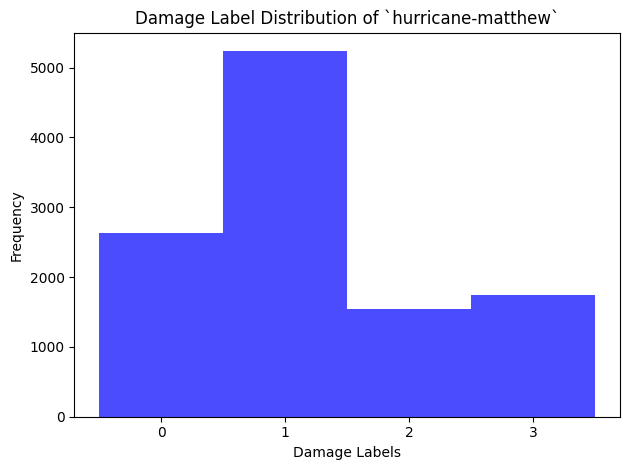

In [5]:
# Get image labels and plot distribution

for disaster in disaster_list:
    # Get labels for each disaster
    disaster_labels = data[disaster]['labels']

    # Print statements of min and max
    print(f"Value counts for labels in {disaster}:\n{pd.Series(data[disaster]['labels']).value_counts().sort_index()}")

    # Create a histogram for label distribution with bins for each label
    plt.hist(disaster_labels, bins=[0, 1, 2, 3, 4], align='left', color=color_dict[disaster], alpha=0.7)
    plt.title(f'Damage Label Distribution of `{disaster}`')
    plt.xlabel('Damage Labels')
    plt.ylabel('Frequency')
    plt.xticks([0, 1, 2, 3])  # Set x-ticks to correspond to the discrete labels

    # Adjust the layout
    plt.tight_layout()
    plt.show()

**Visualizing the distribution of color channel intensities (red, green, blue) per disaster:**

From looking at the histograms, it may be worthwhile to consider the mean intensity of images per disaster in completing Task 1, as the average from each color channel in `socal-fire` is higher than in `midwest-flooding`. Since `hurricane-matthew` will be compared amongst the damage labels, additional EDA will be conducted to visualize the distribution of intensities per label.


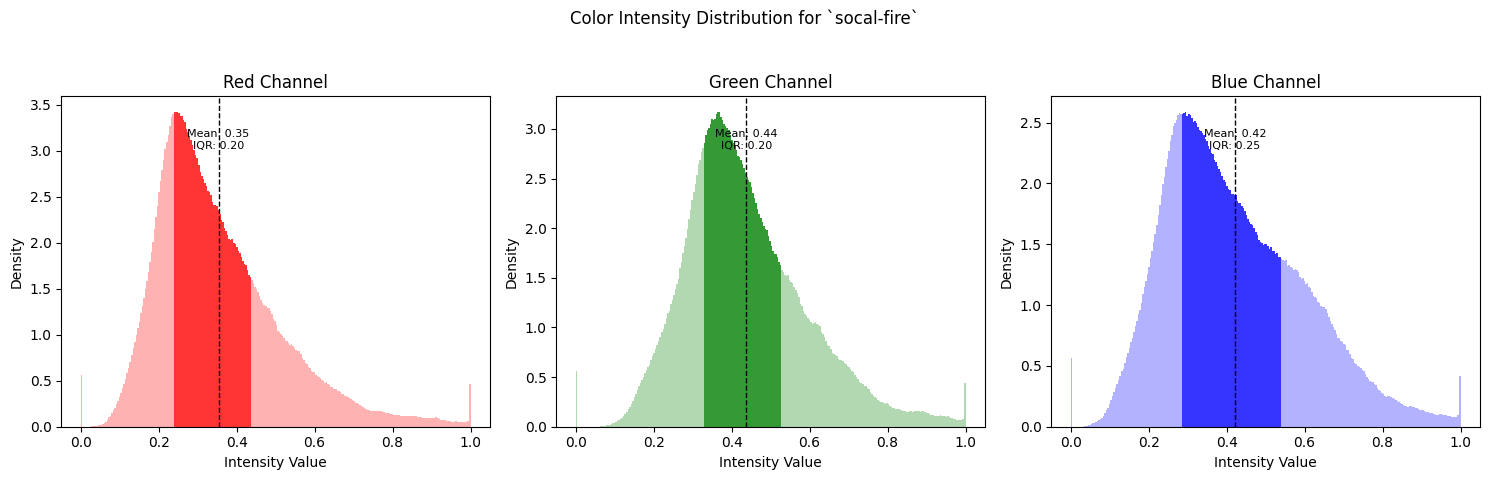

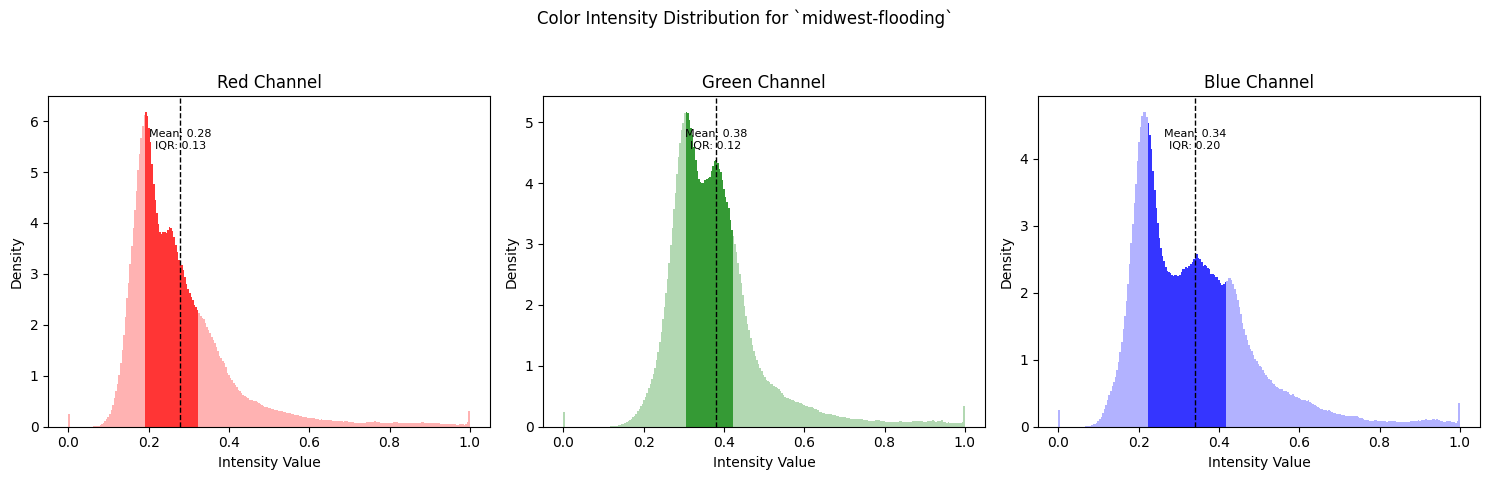

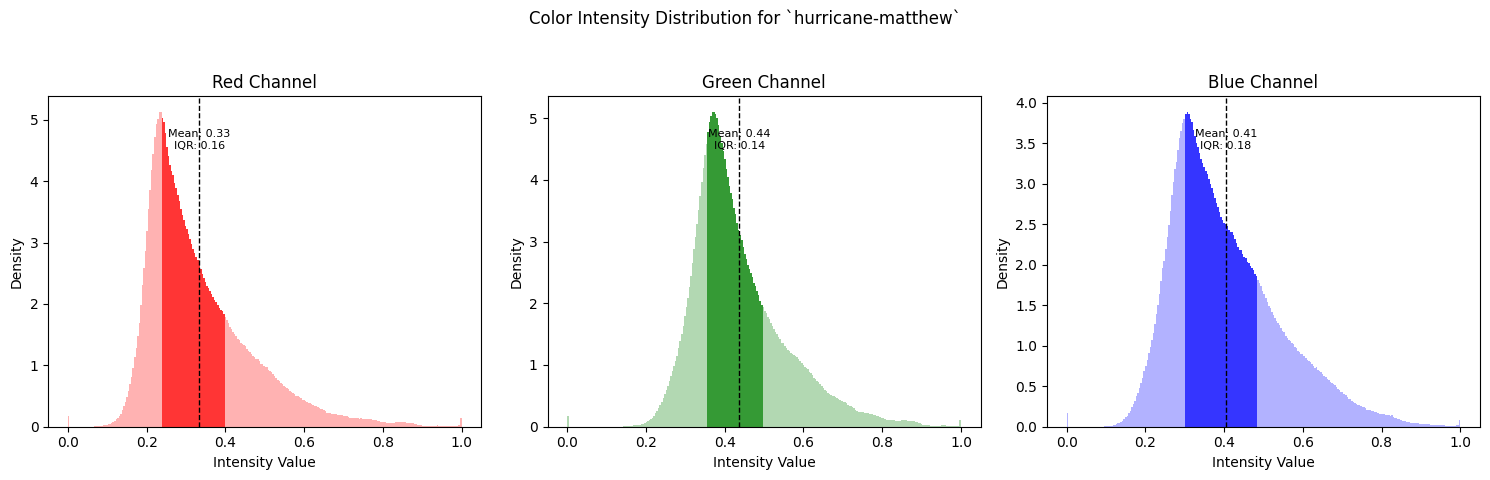

In [6]:
# Look at color values for images in each disaster classification

common_size = (128, 128)  # Normalize image size for consistency
num_samples = 500

for disaster in disaster_list:
    # Accumulators for color intensities across all images in the disaster
    color_accumulators = {'red': [], 'green': [], 'blue': []}
    disaster_img_dataset = data[disaster]['images']

    # Take a random sample of the image dataset
    sampled_indices = np.random.choice(range(len(disaster_img_dataset)), size=min(num_samples, len(disaster_img_dataset)), replace=False)
    sampled_images = [disaster_img_dataset[i] for i in sampled_indices]

    for img in sampled_images:
        # Resize data transforamtion to common size
        img_resized = resize(img, common_size, anti_aliasing=True)
        img_flat = img_resized.reshape(-1, 3)

        # Normalize color intensities to 0-1 range
        img_normalized = img_flat / 255.0

        # Accumulate color intensities
        color_accumulators['red'].extend(img_flat[:, 0])
        color_accumulators['green'].extend(img_flat[:, 1])
        color_accumulators['blue'].extend(img_flat[:, 2])

    # Plotting the density histograms and mean for each color channel across the disaster
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Color Intensity Distribution for `{disaster}`")

    for i, color in enumerate(['red', 'green', 'blue']):
        plt.subplot(1, 3, i+1)

        color_data = np.array(color_accumulators[color])
        q1, q3 = np.percentile(color_data, [25, 75])
        iqr = q3 - q1

        # Histogram for the full data
        counts, bins, _ = plt.hist(color_data, bins=256, color=color, alpha=0.3, density=True)

        # Highlighting the IQR
        bin_centers = (bins[:-1] + bins[1:]) / 2
        for count, bin_center in zip(counts, bin_centers):
            if q1 <= bin_center <= q3:
                plt.bar(bin_center, count, width=bins[1]-bins[0], color=color, alpha=0.7, align='center')

        avg_intensity = color_data.mean()
        plt.axvline(avg_intensity, color='k', linestyle='dashed', linewidth=1)
        plt.title(f'{color.capitalize()} Channel')
        plt.xlabel('Intensity Value')
        plt.ylabel('Density')
        plt.text(avg_intensity, plt.ylim()[1]*0.9, f'Mean: {avg_intensity:.2f}\nIQR: {iqr:.2f}', ha='center', va='top', fontsize=8, color='k')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**Defining Sobel, LBP, and Gabor feature extraction functions:**

The following functions will be used to extract features related to the means and variances of images when applying various image processing filters.


In [7]:
def generate_gabor_kernels(theta_vals, sigma_vals, frequency_vals):
    """
    Generate a collection of Gabor filter kernels with specified parameters.

    Args:
        theta_vals (list or array): Range of orientations for the Gabor filter kernels.
        sigma_vals (list or array): Range of sigma values (bandwidths) for the kernels.
        frequency_vals (list or array): Range of frequencies for the kernels.

    Returns:
        list: A list of Gabor kernels with specified parameters.
    """
    kernels = []
    for theta in theta_vals:
        for sigma in sigma_vals:
            for frequency in frequency_vals:
                kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    return kernels

def extract_combined_features(image, gabor_kernels):
    """
    Extract combined features (Sobel, Gabor, LBP) from an image and summarize with statistical measures.
    This version supports multiple Gabor kernels.

    Args:
        image (ndarray): An image array in RGB format.
        gabor_kernels (list): A list of Gabor kernels for feature extraction.

    Returns:
        ndarray: A 1D array (feature vector) summarizing the extracted features.
    """
    # Initialize dictionary to collect features
    features_dict = {}

    # Sobel features
    sobel_features = get_sobel_features(image).flatten()
    features_dict['sobel_mean'] = sobel_features.mean()
    features_dict['sobel_var'] = sobel_features.var()

    # Gabor features
    for i, kernel in enumerate(gabor_kernels):
        gabor_features = get_gabor_features(image, kernel).flatten()
        features_dict[f'gabor_{i}_mean'] = gabor_features.mean()
        features_dict[f'gabor_{i}_var'] = gabor_features.var()

    # LBP features
    lbp_features = get_local_binary_pattern(image).flatten()
    features_dict['lbp_mean'] = lbp_features.mean()
    features_dict['lbp_var'] = lbp_features.var()

    return features_dict


def visualize_feature_distribution(feature_df, disaster_type):
    """
    Visualize the distribution of the summary statistics for each dataset.

    Args:
        feature_df (DataFrame): DataFrame where each row is a feature vector and each column is a feature.
    """
    feature_names = feature_df.columns

    for feature_name in feature_names:
        plt.figure(figsize=(10, 6))
        sns.histplot(feature_df[feature_name], kde=True, bins=20)
        plt.title(f'Distribution of `{feature_name}` of `{disaster_type}`')
        plt.xlabel(feature_name)
        plt.ylabel('Density')
        plt.show()

**Extracting and visualizing the feature space of each disaster under different image processing filters:**


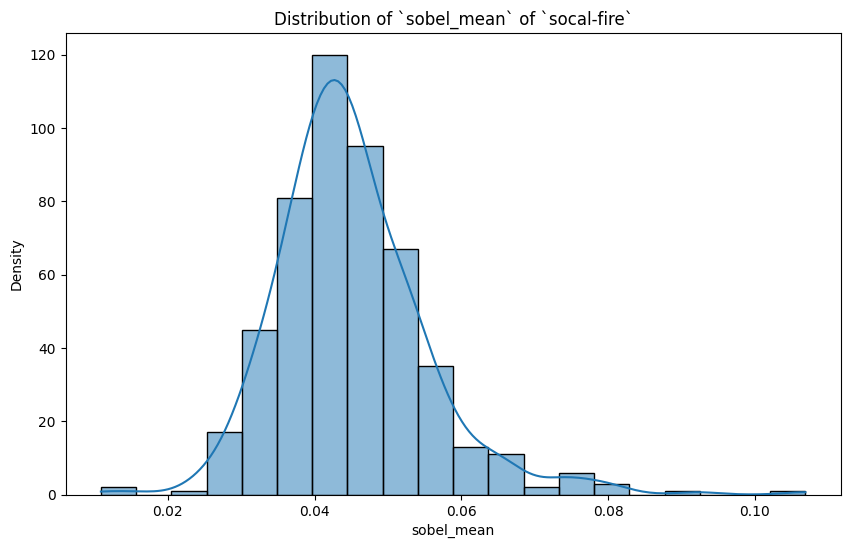

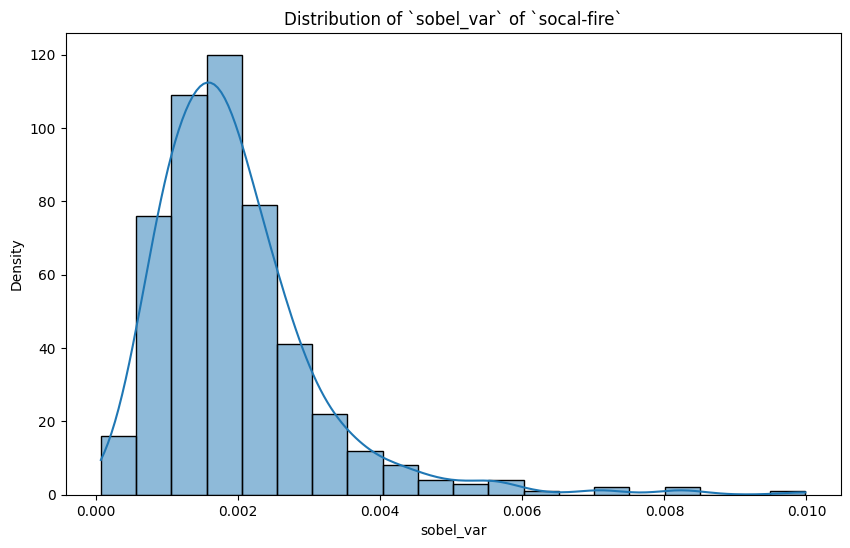

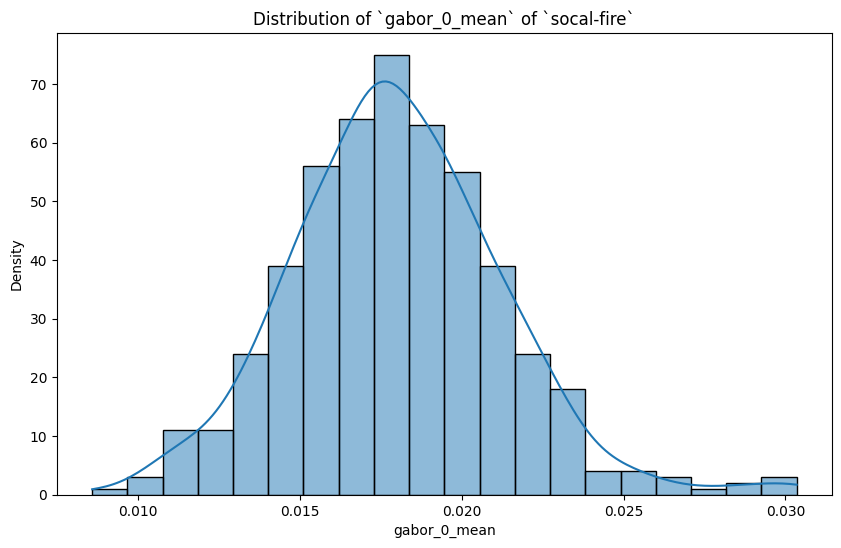

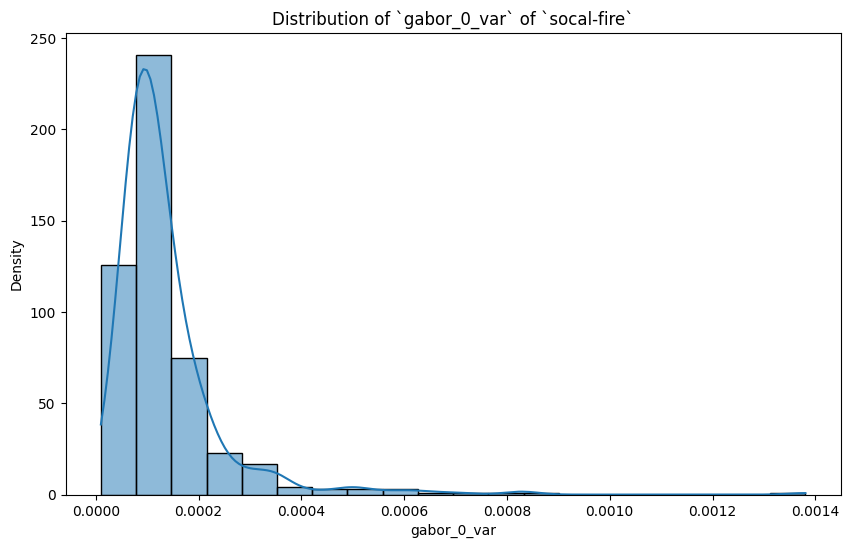

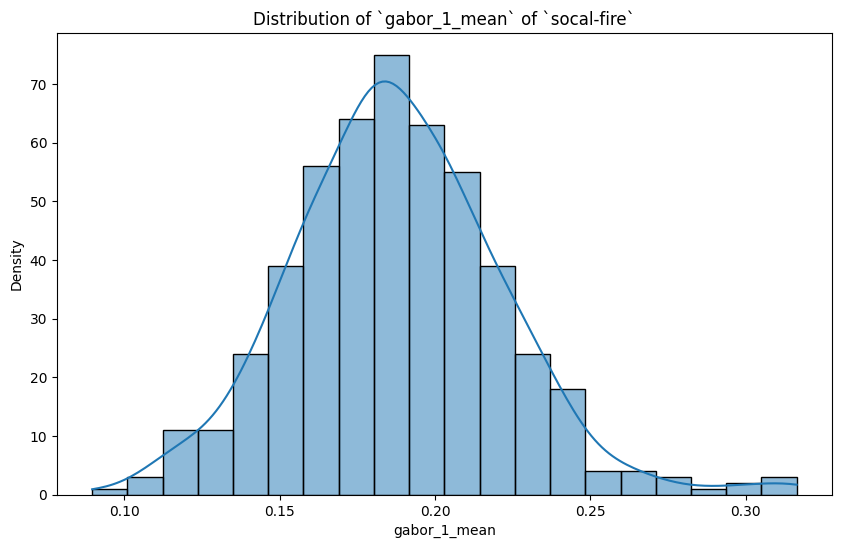

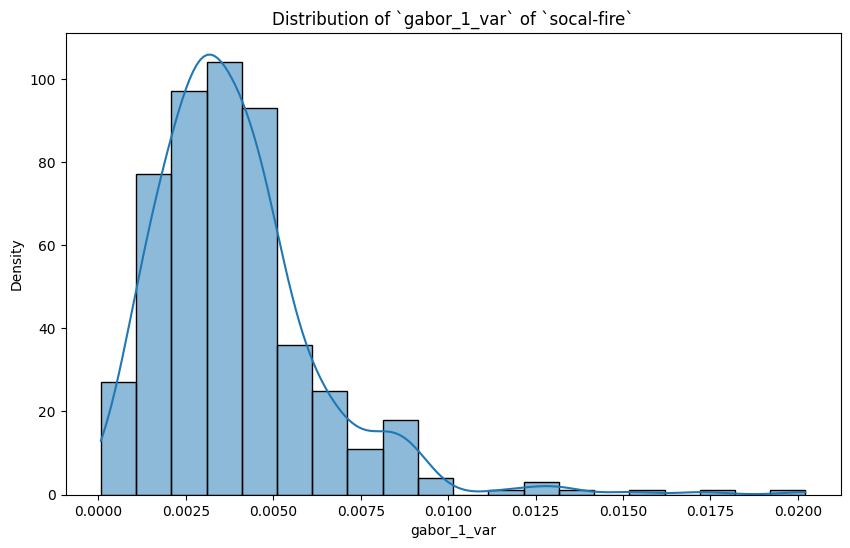

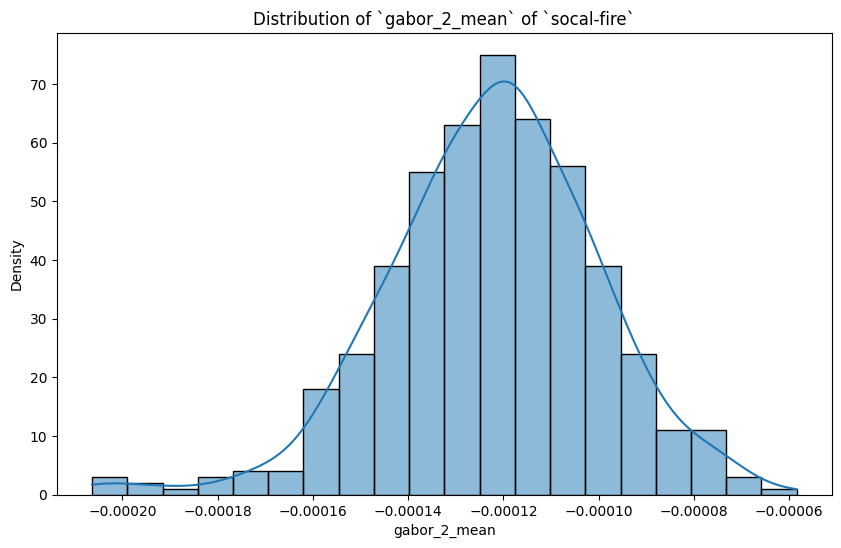

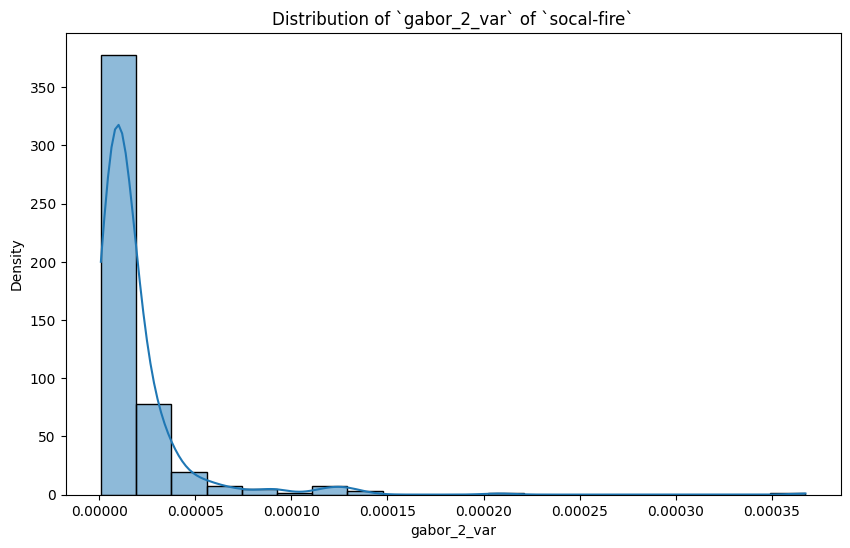

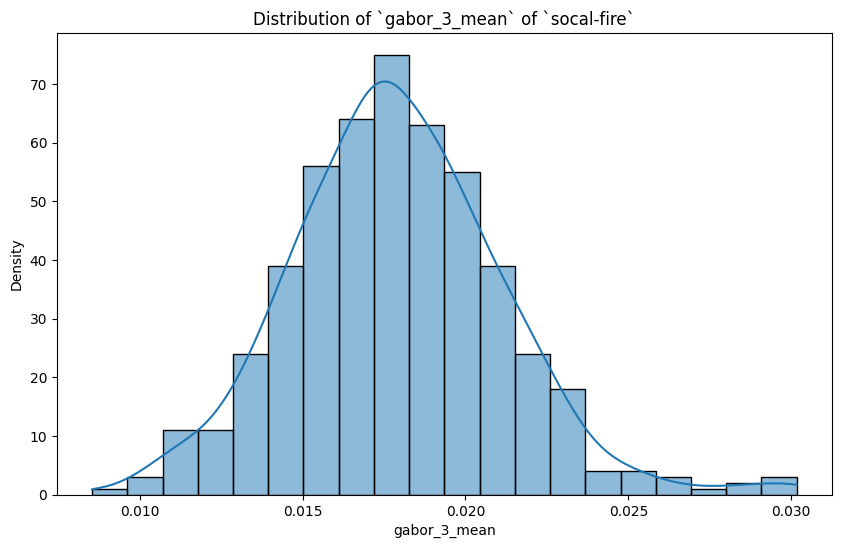

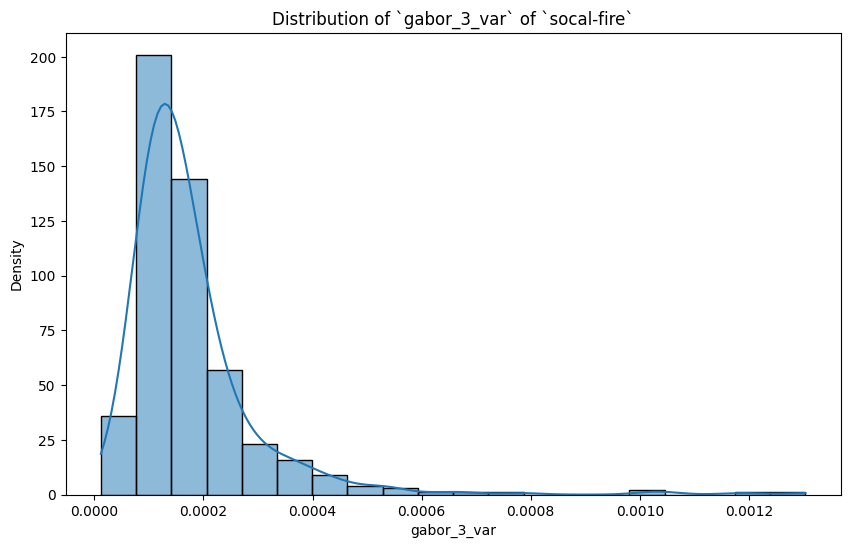

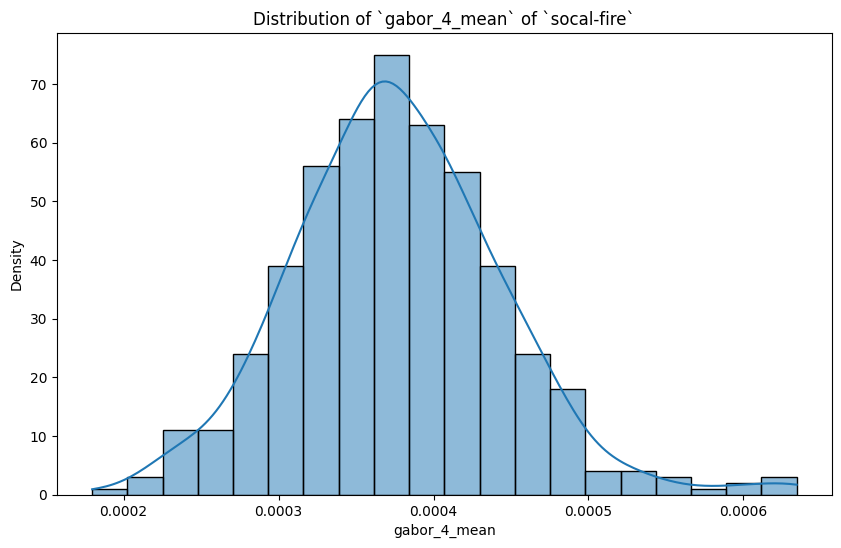

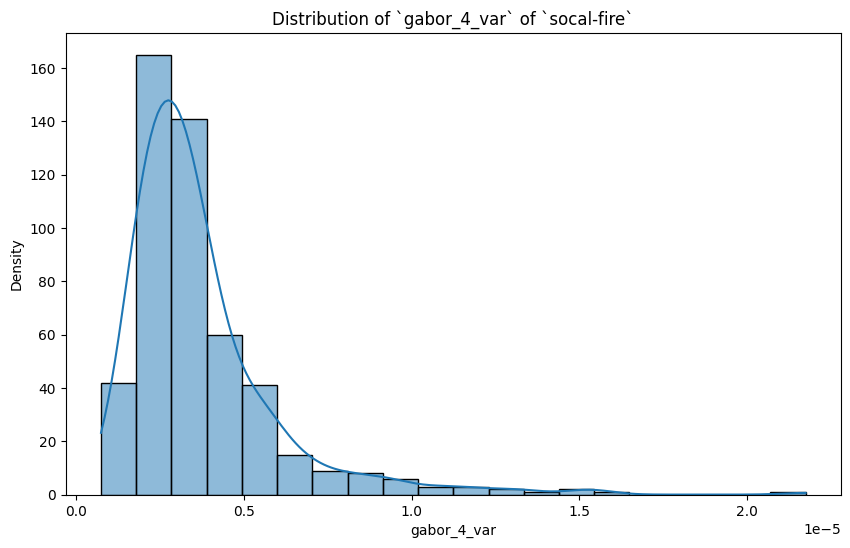

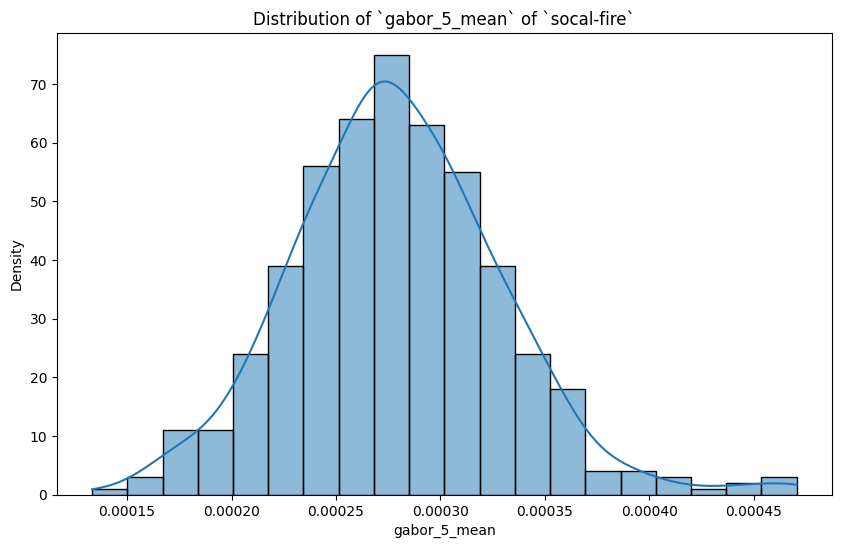

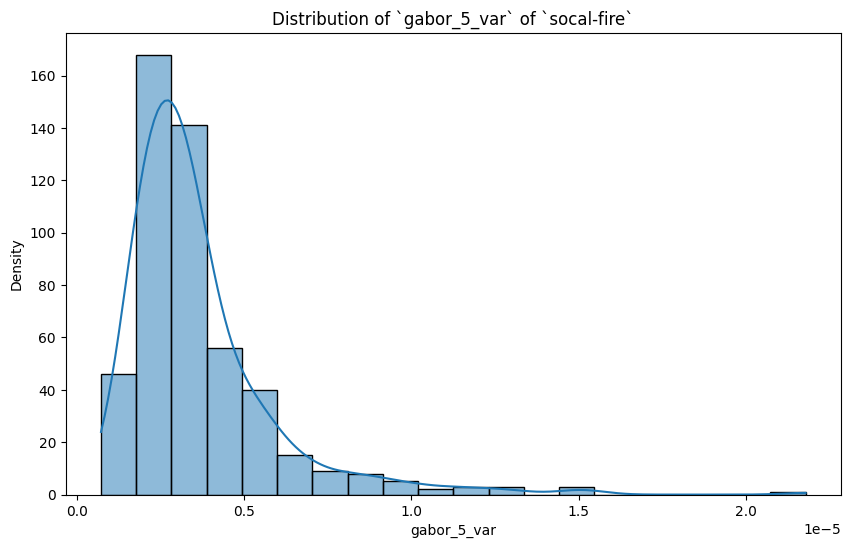

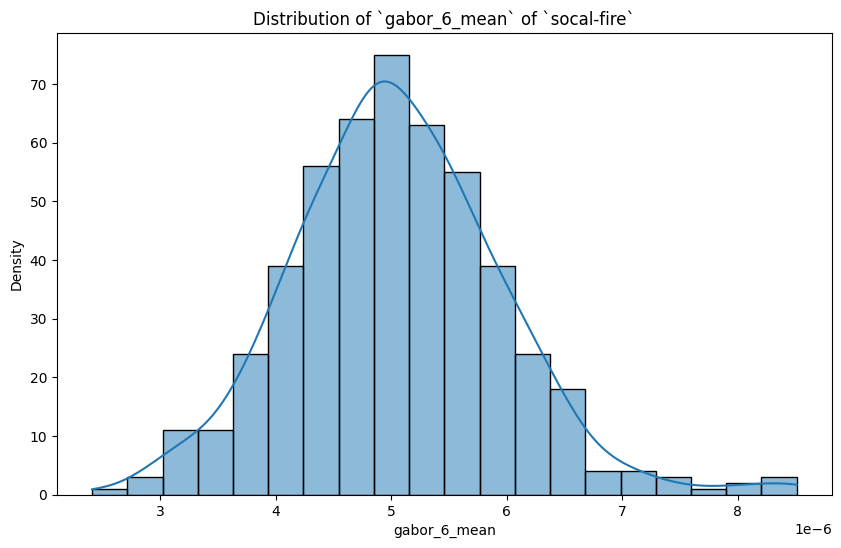

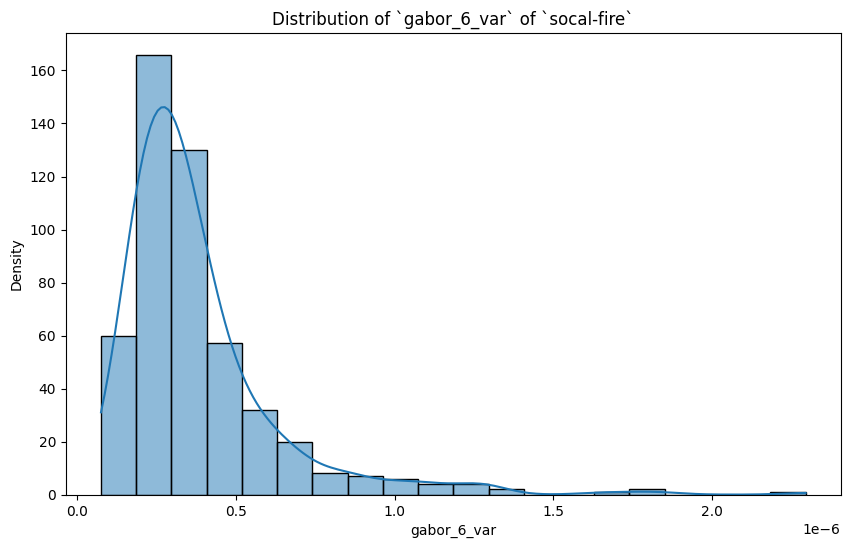

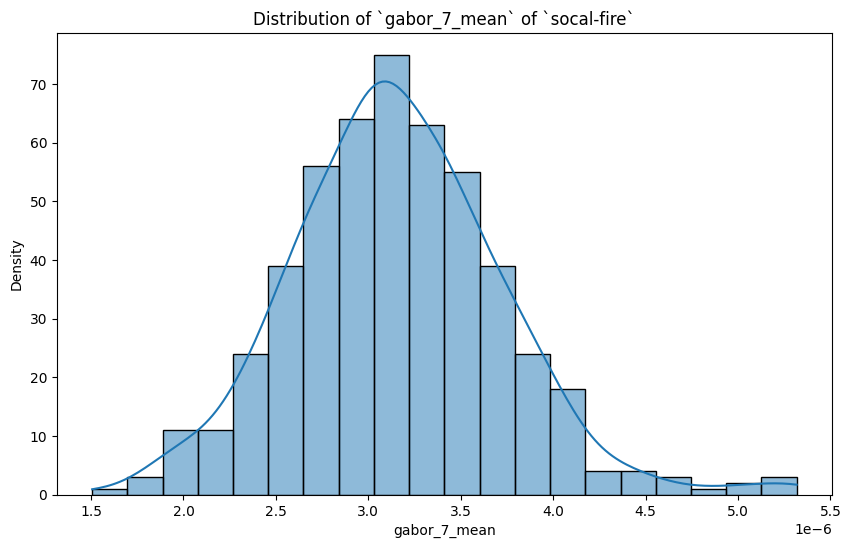

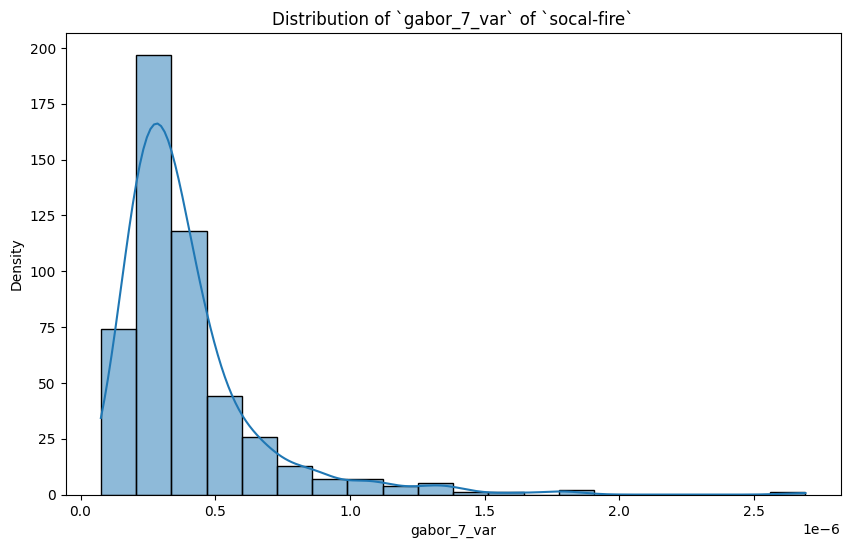

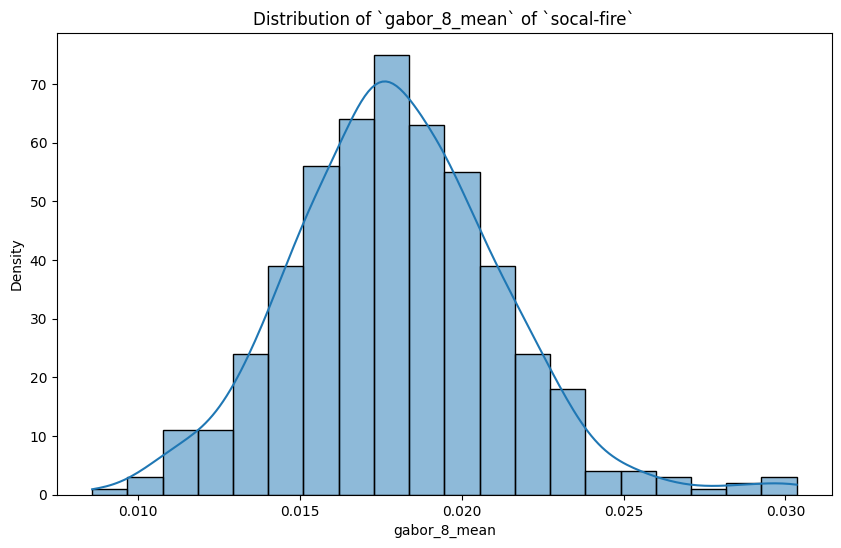

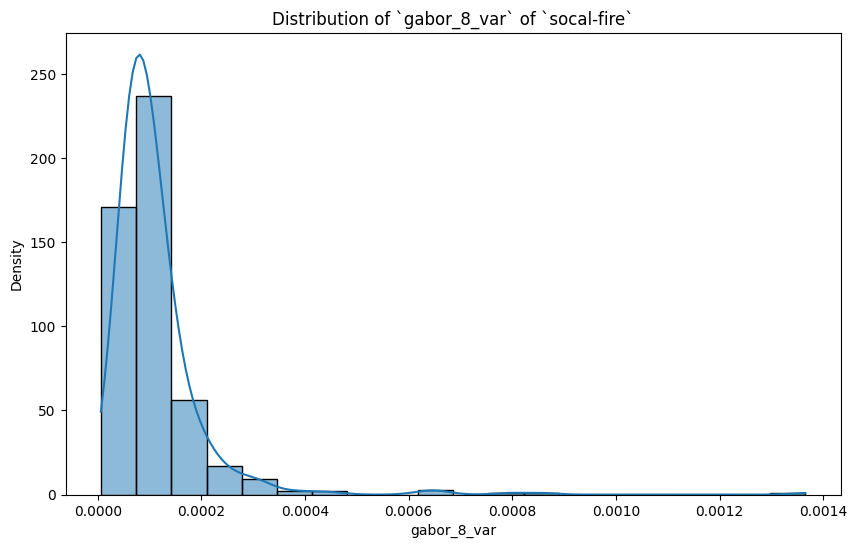

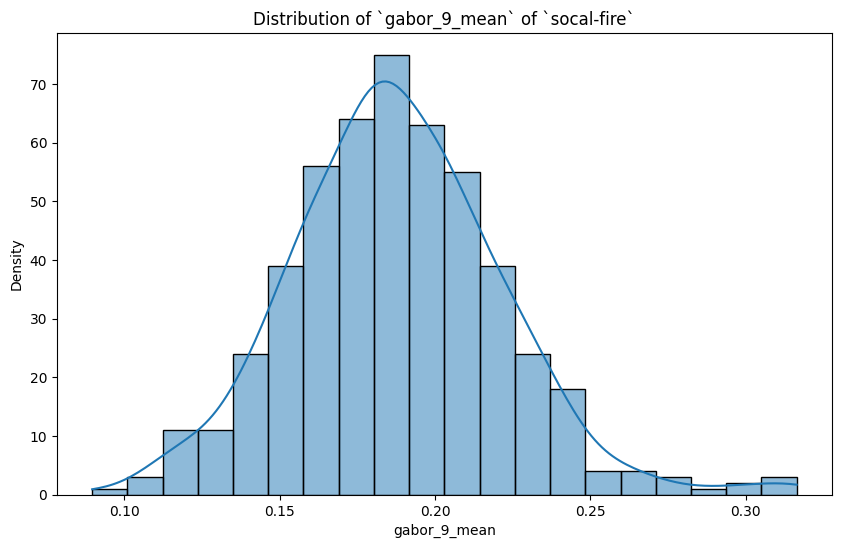

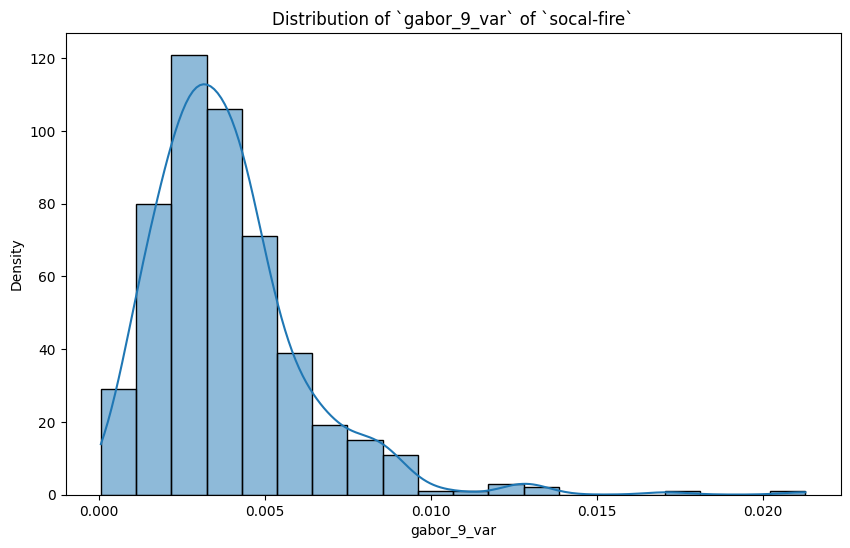

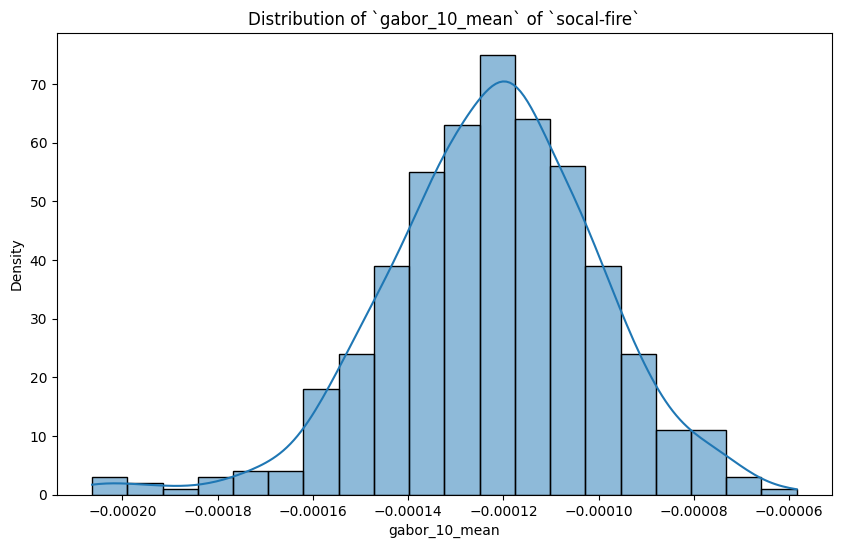

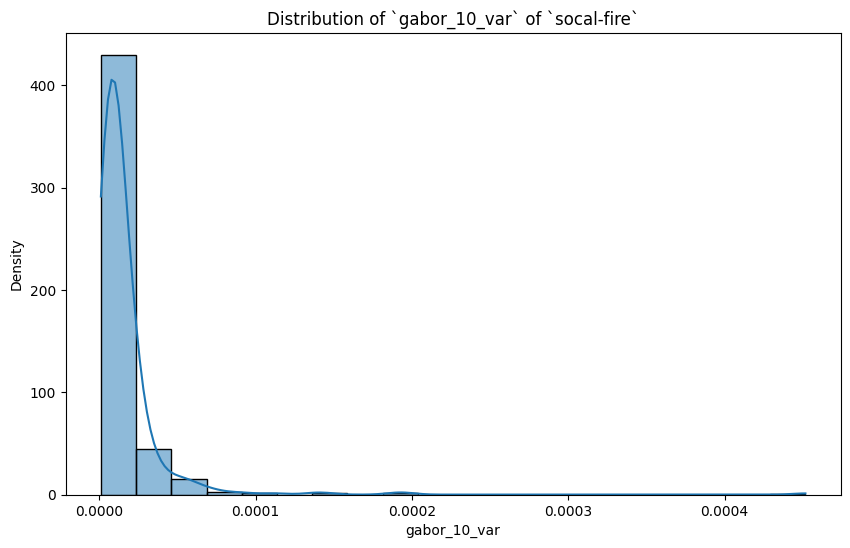

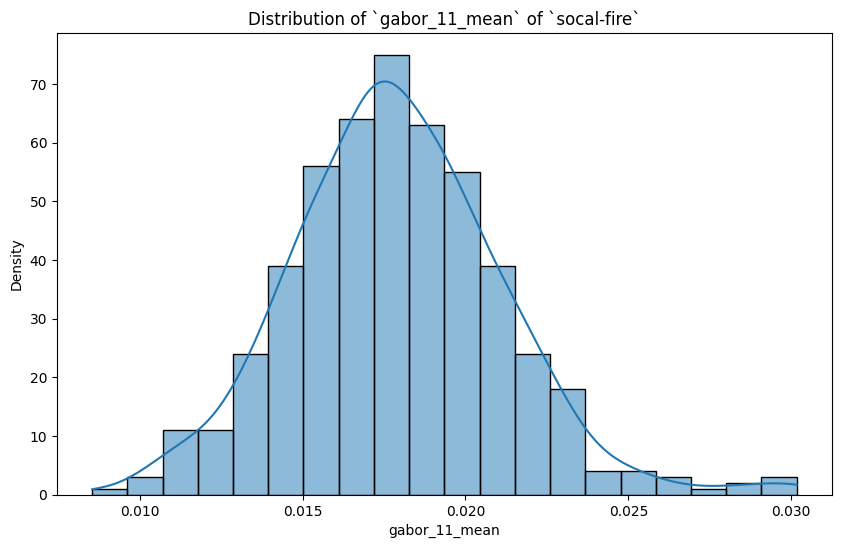

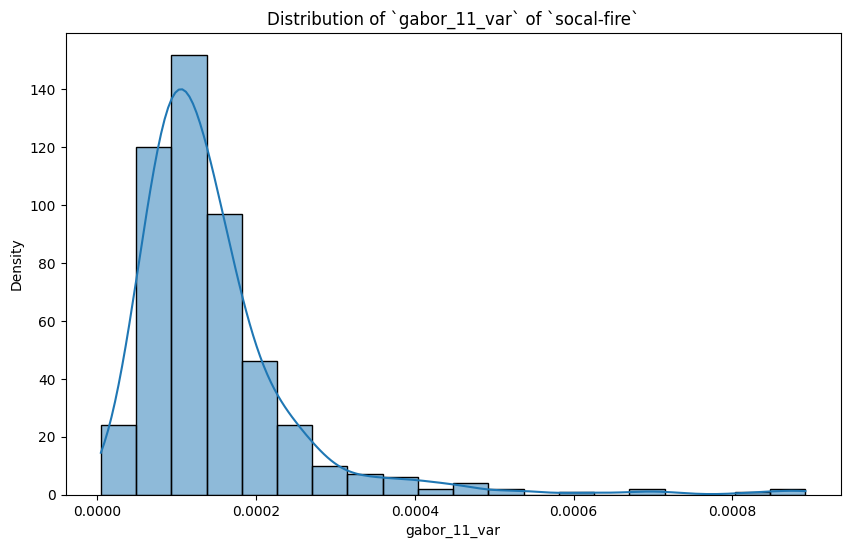

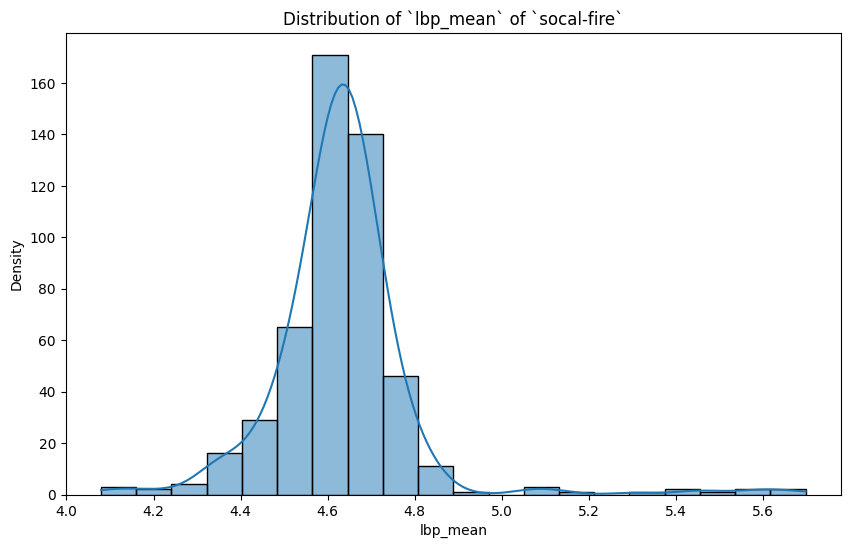

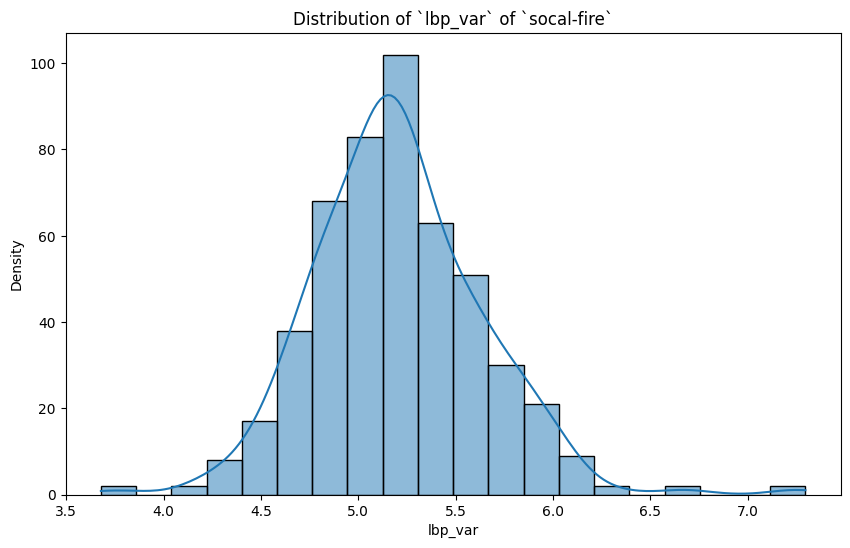

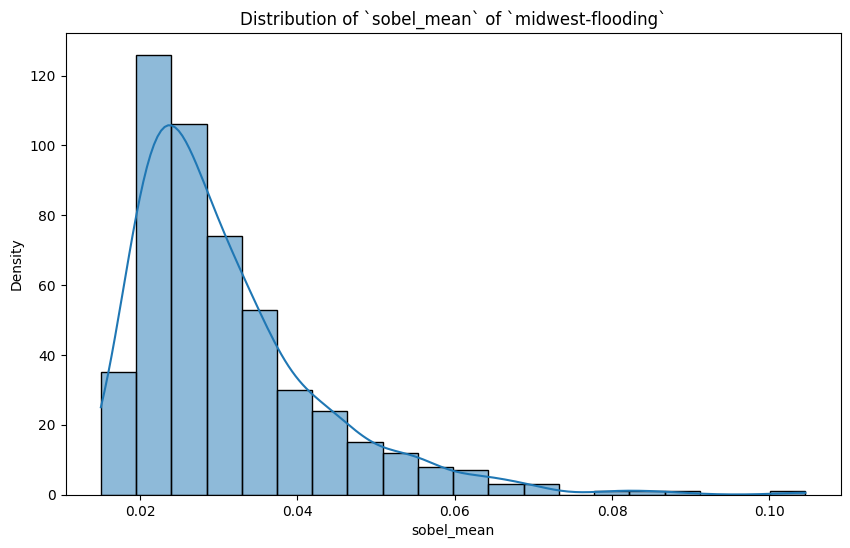

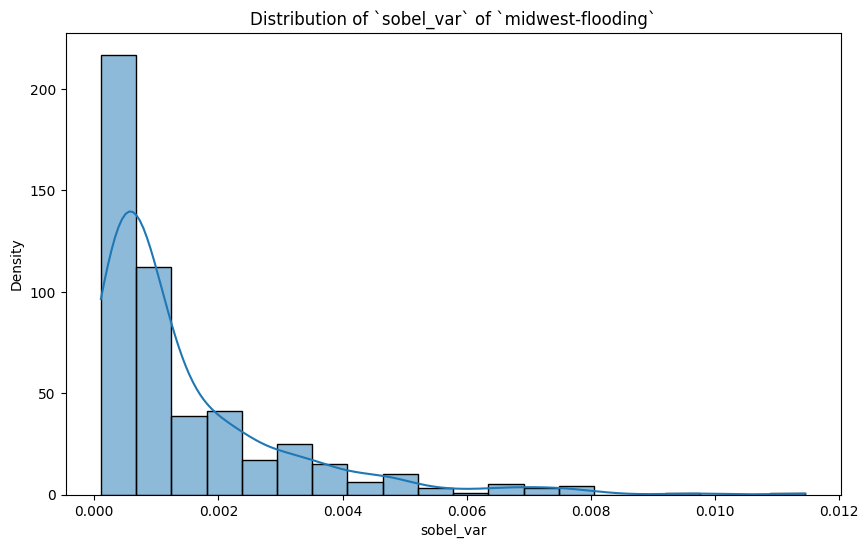

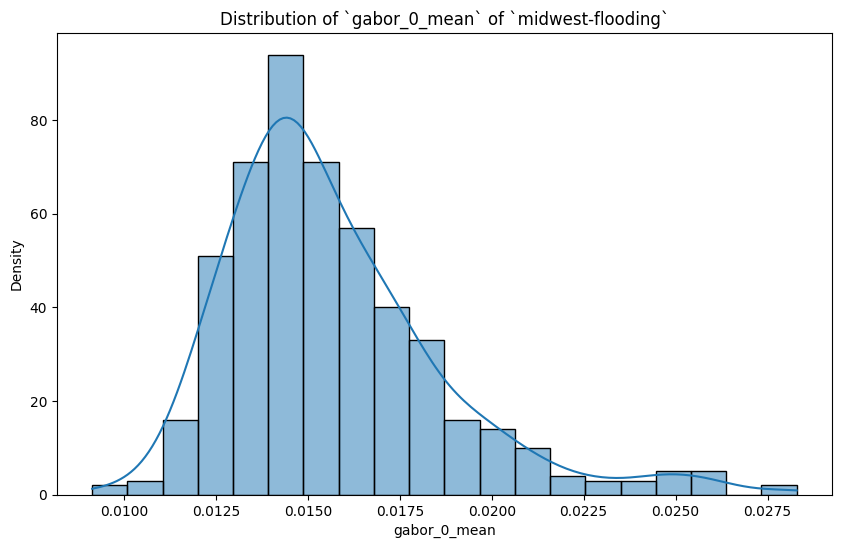

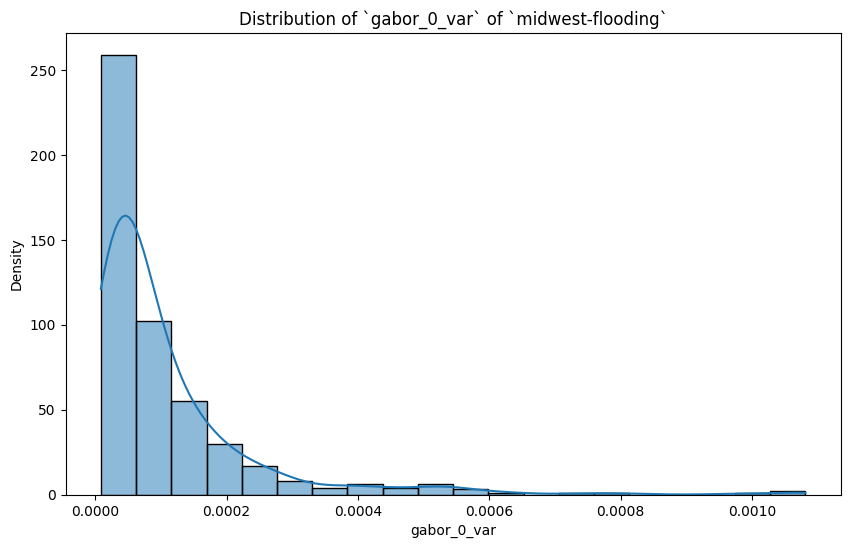

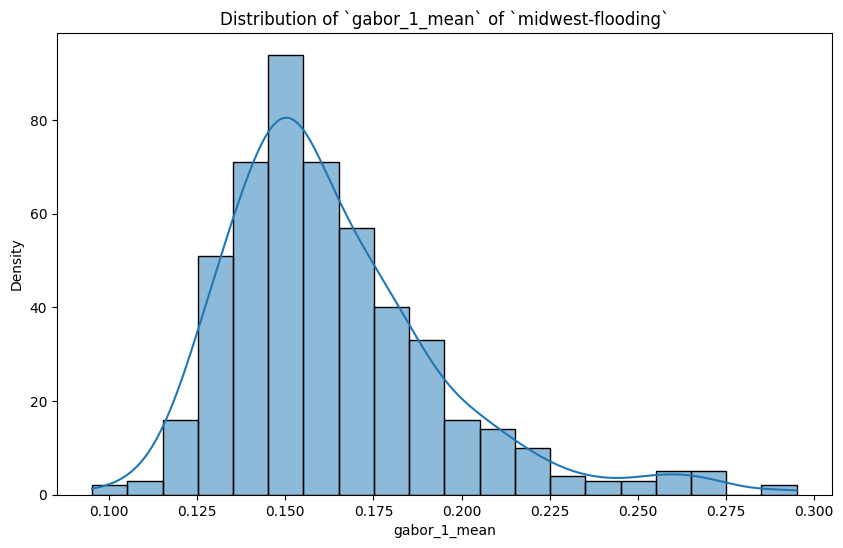

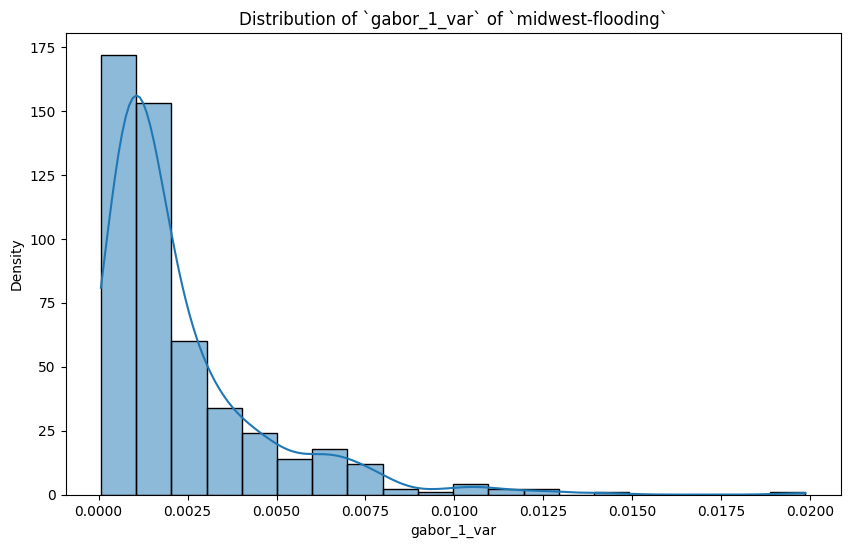

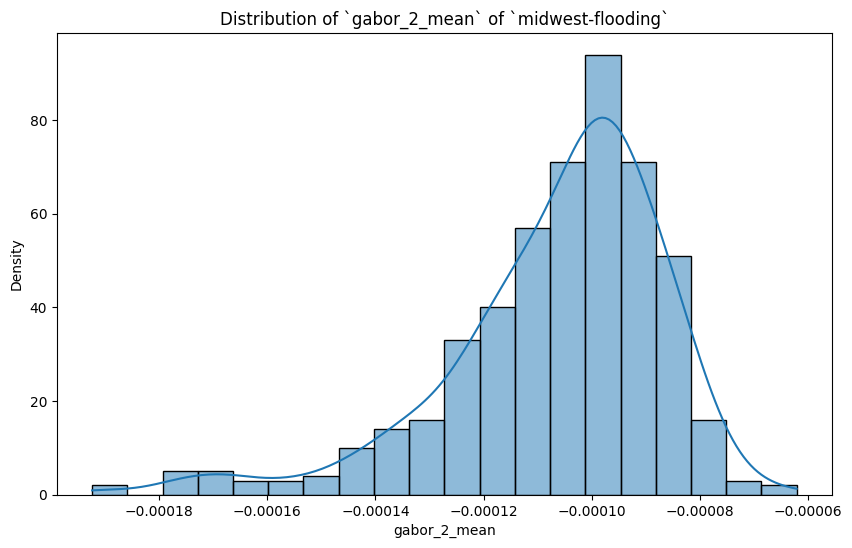

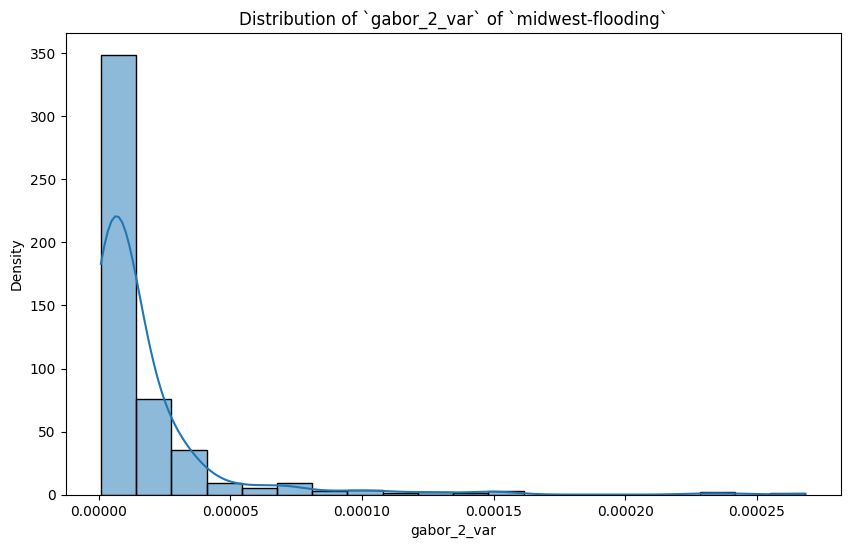

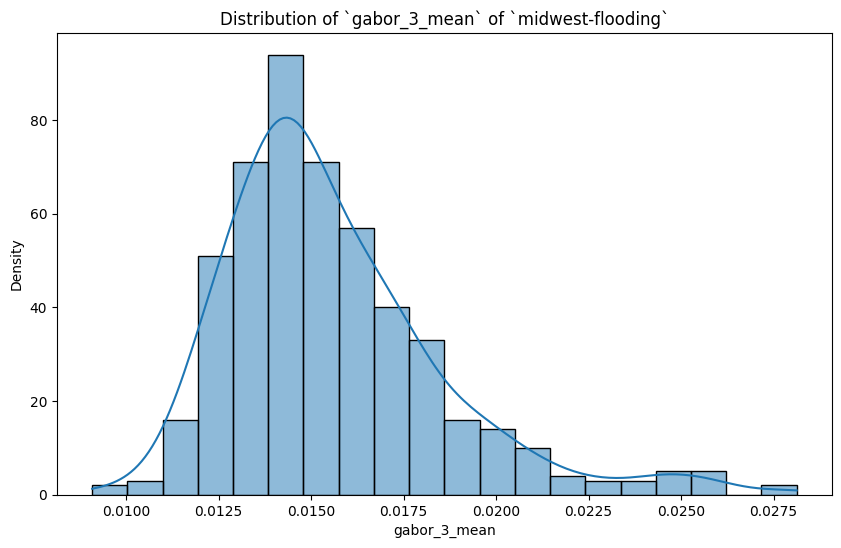

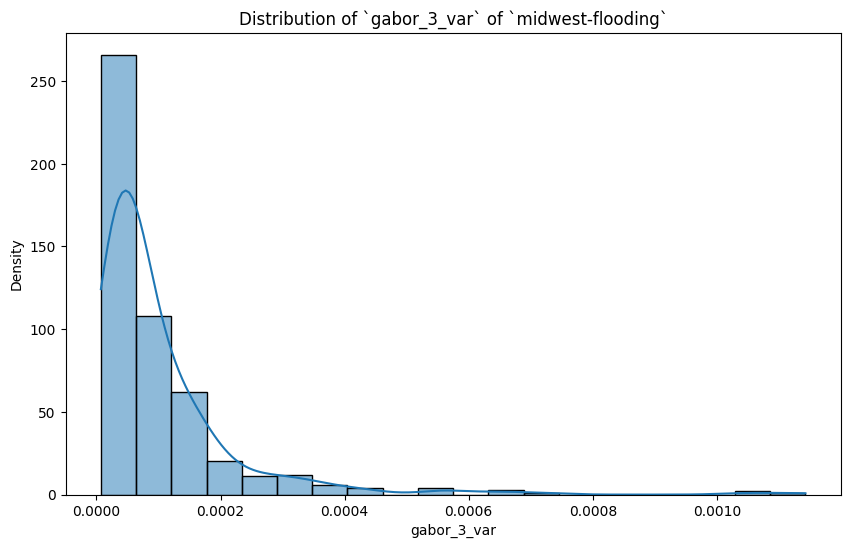

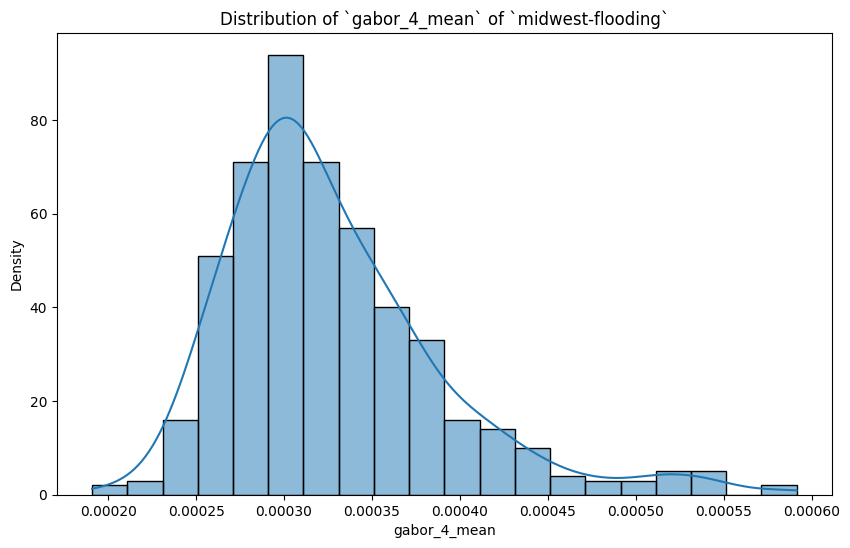

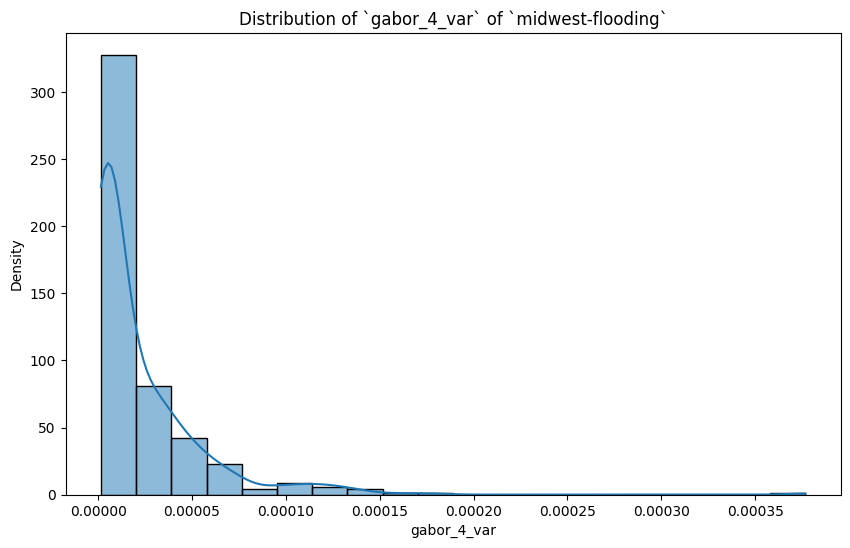

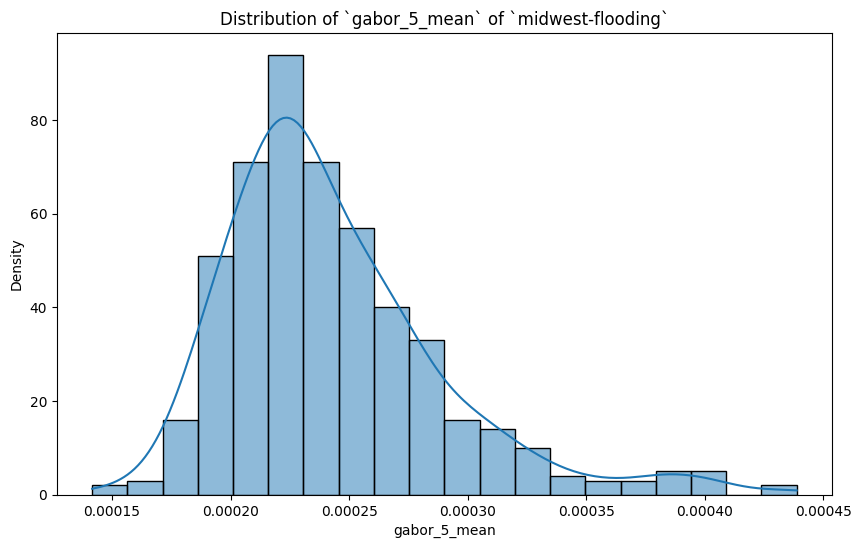

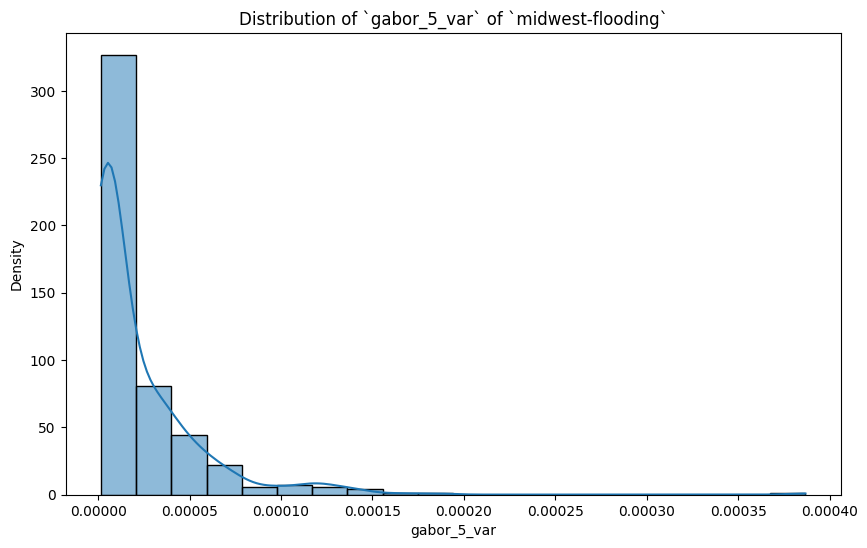

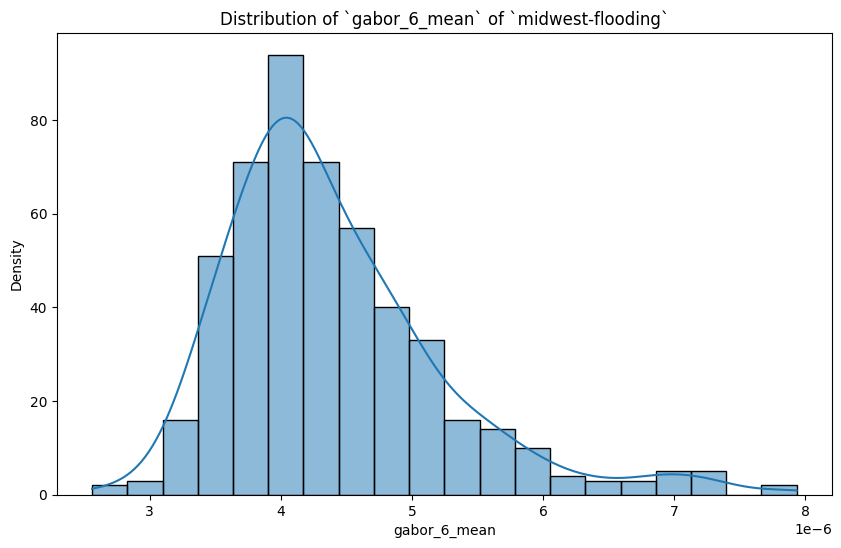

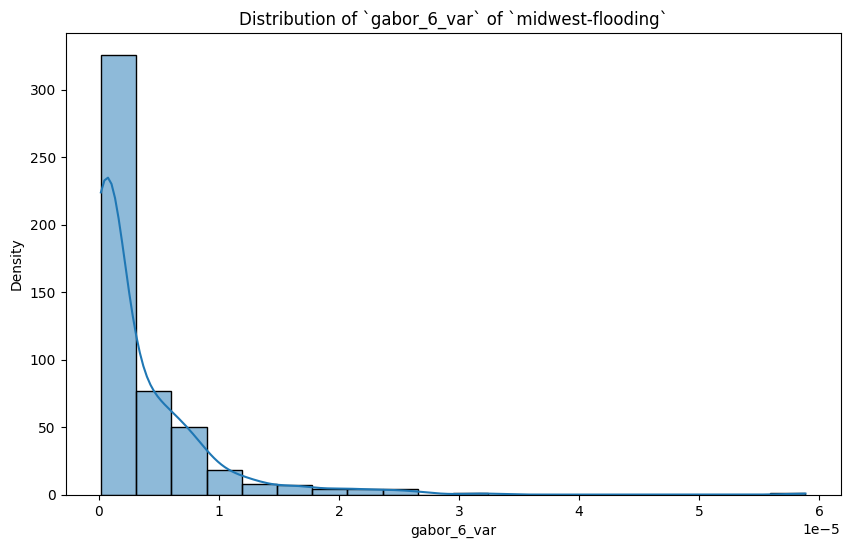

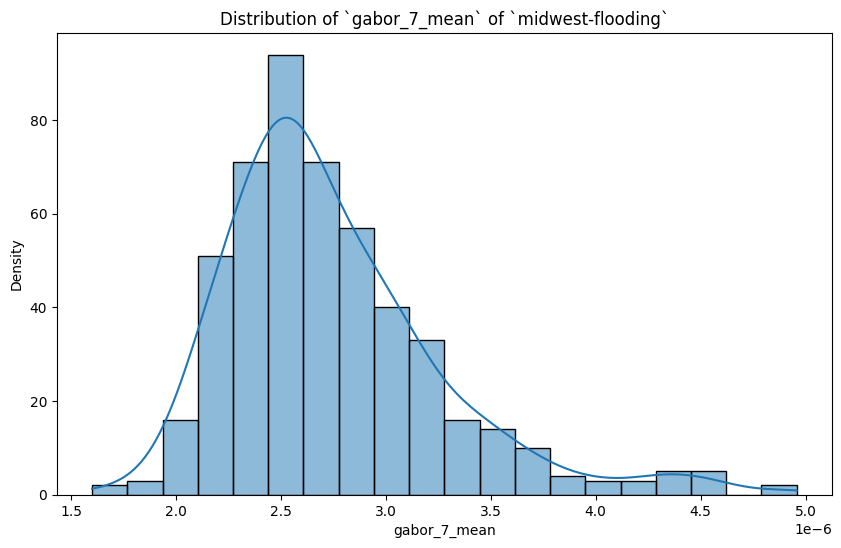

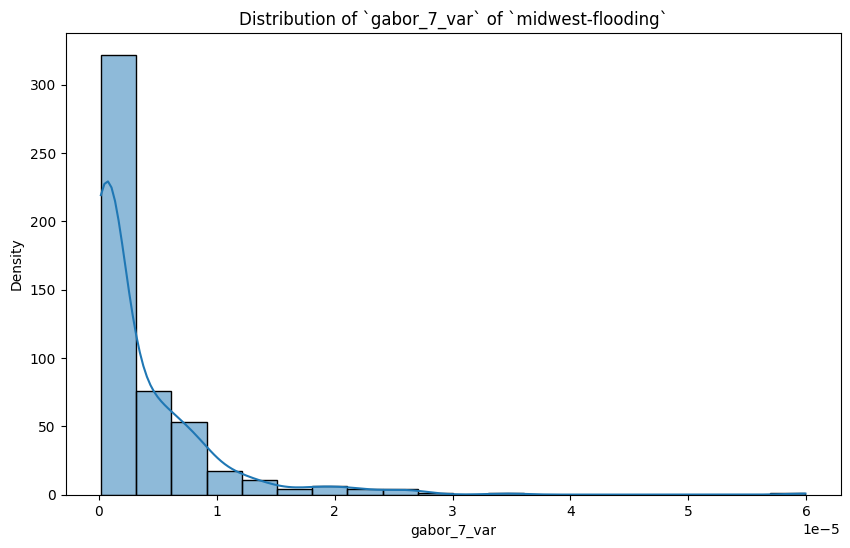

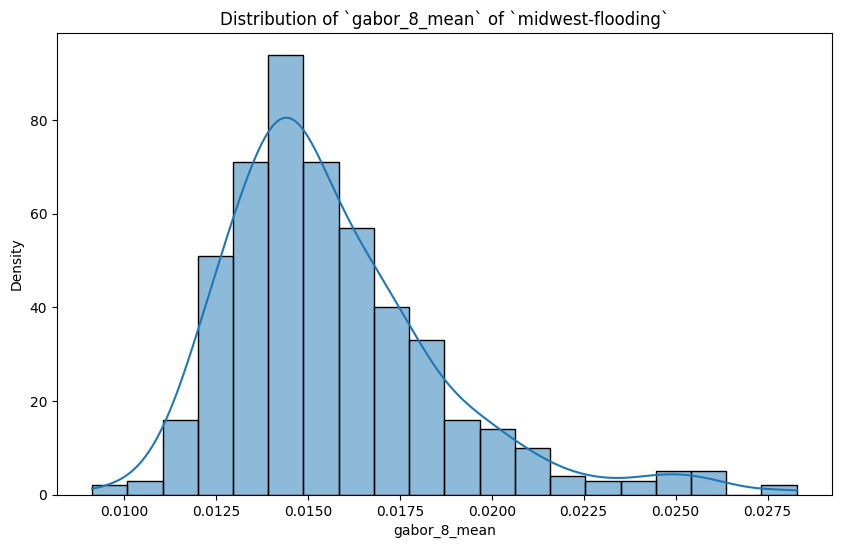

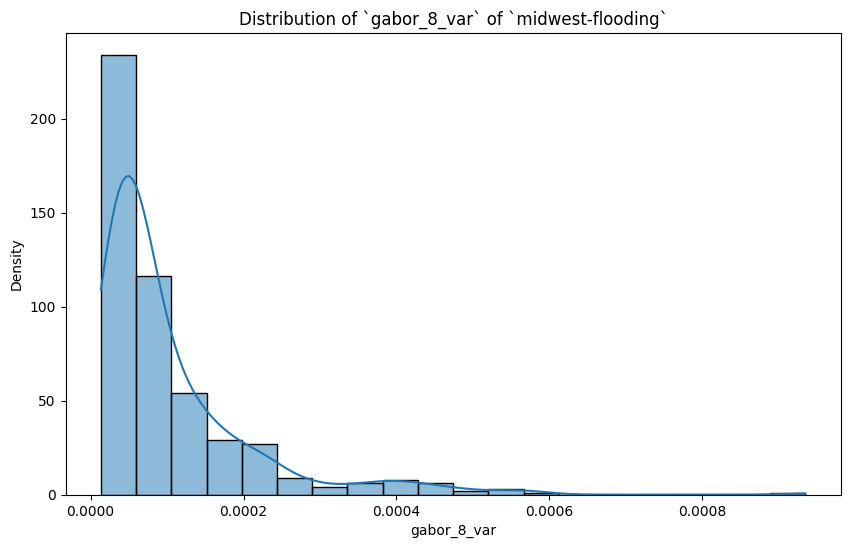

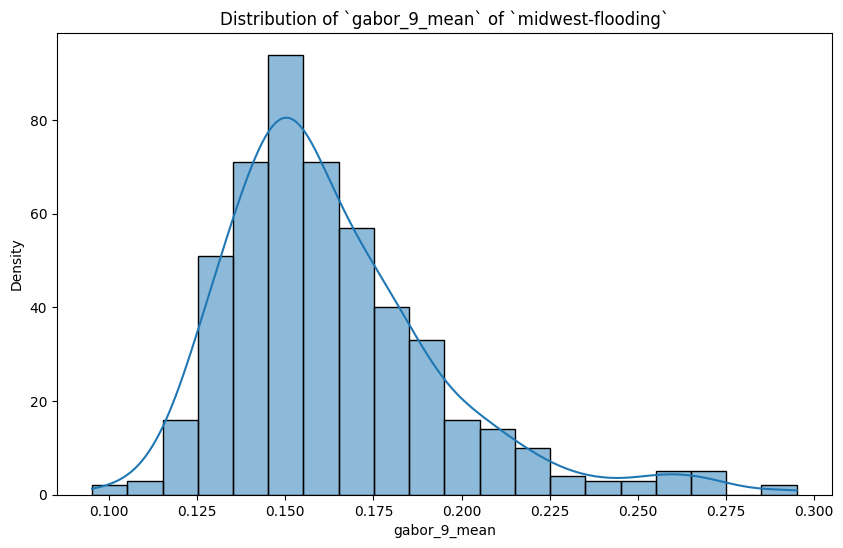

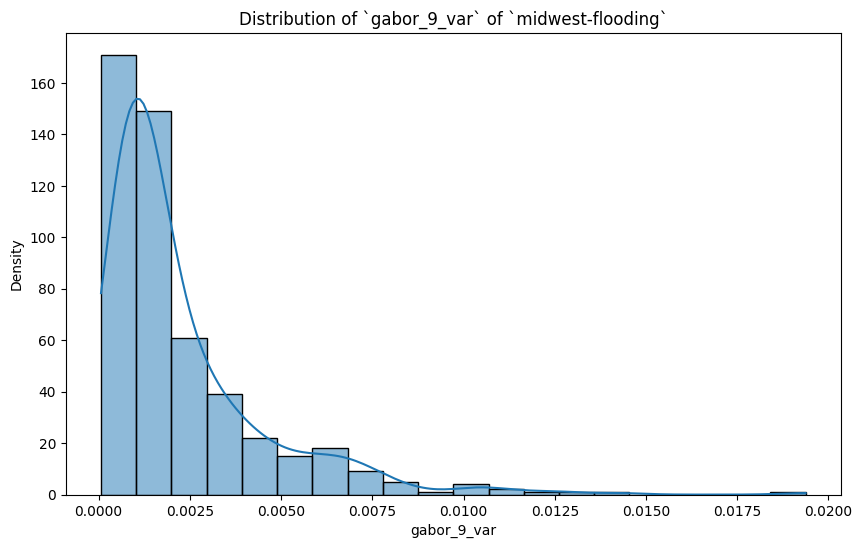

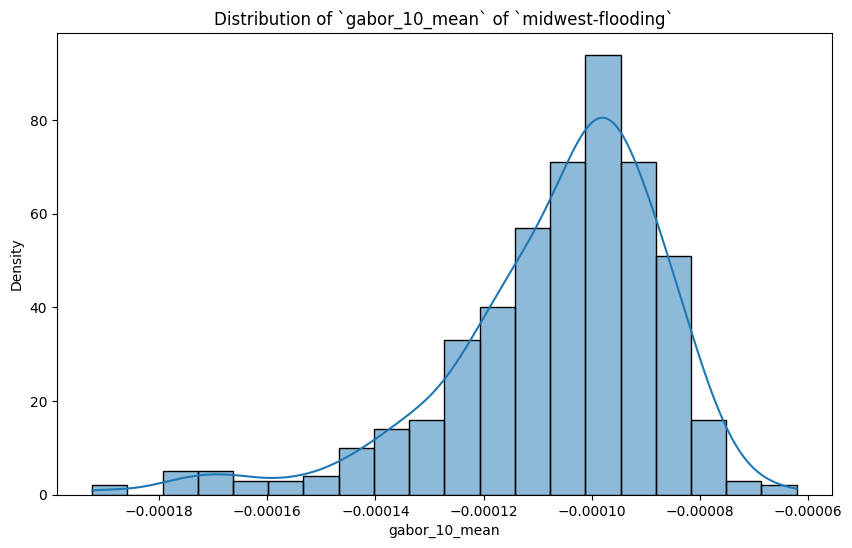

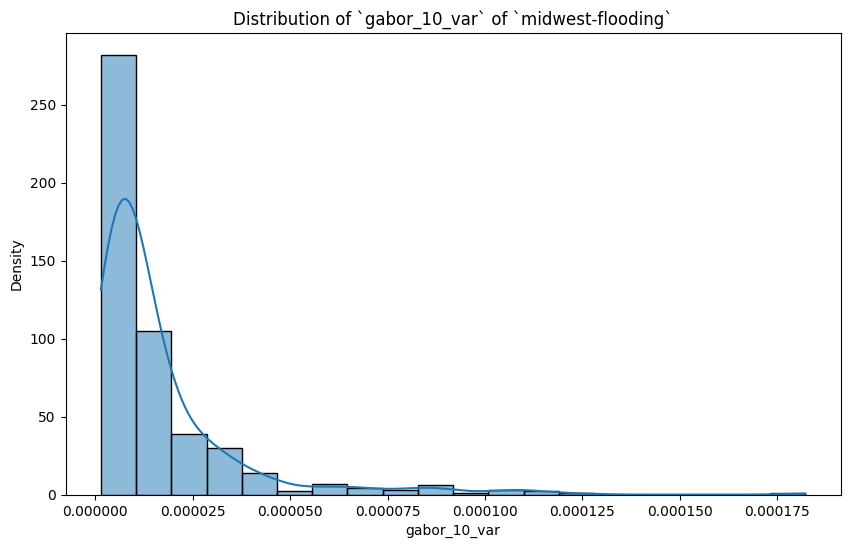

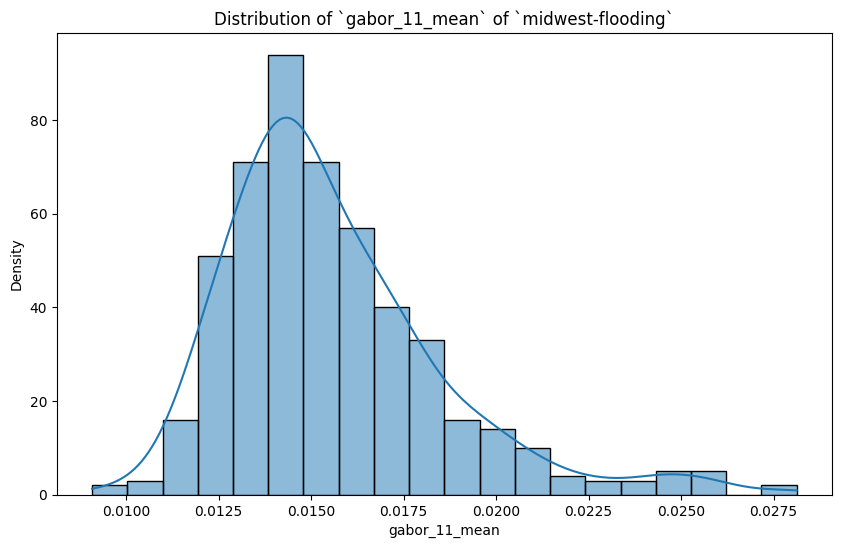

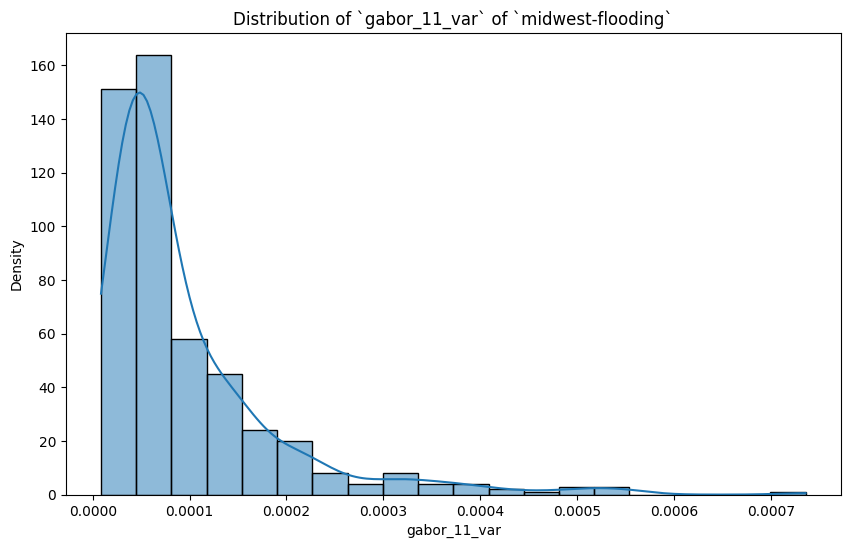

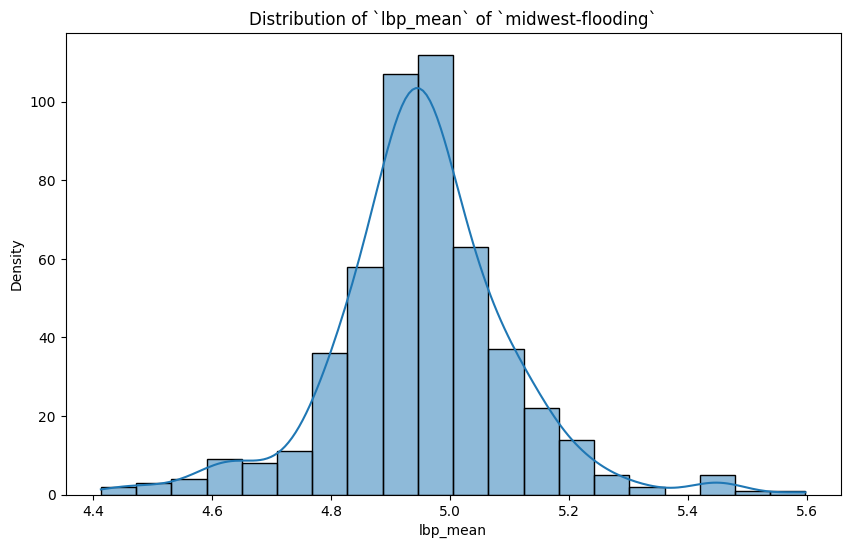

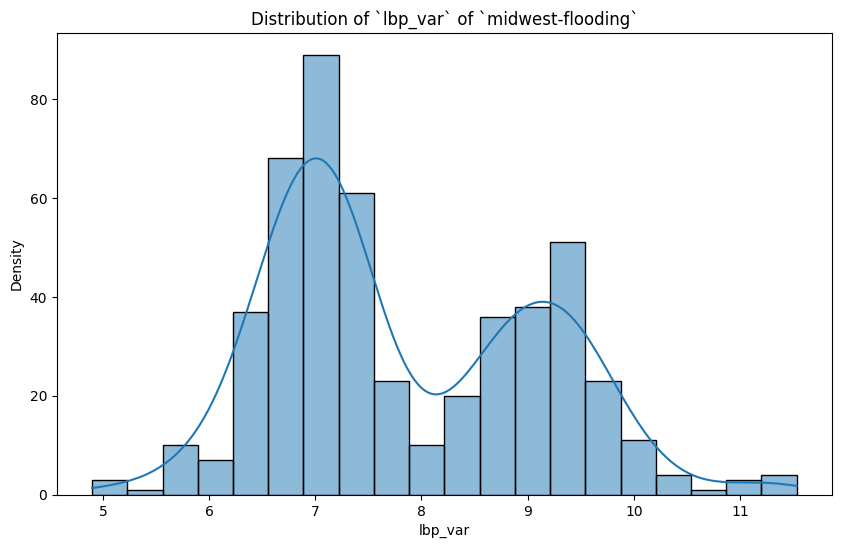

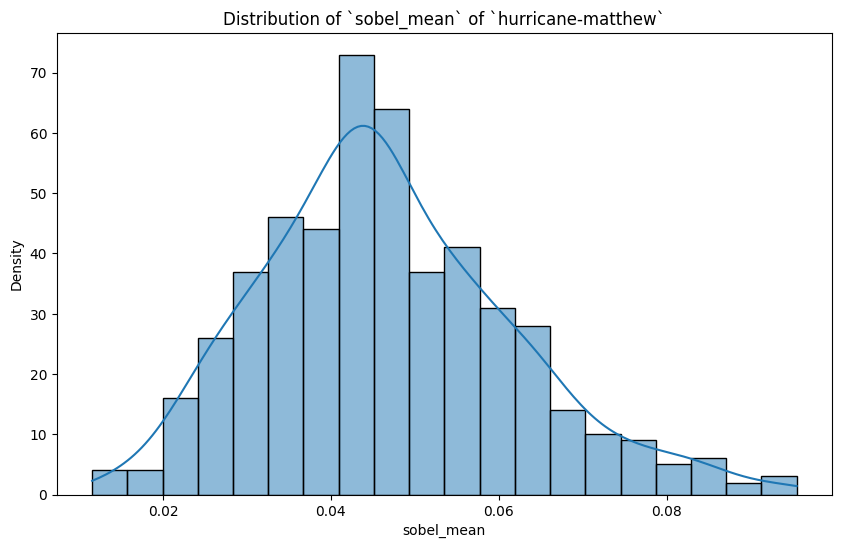

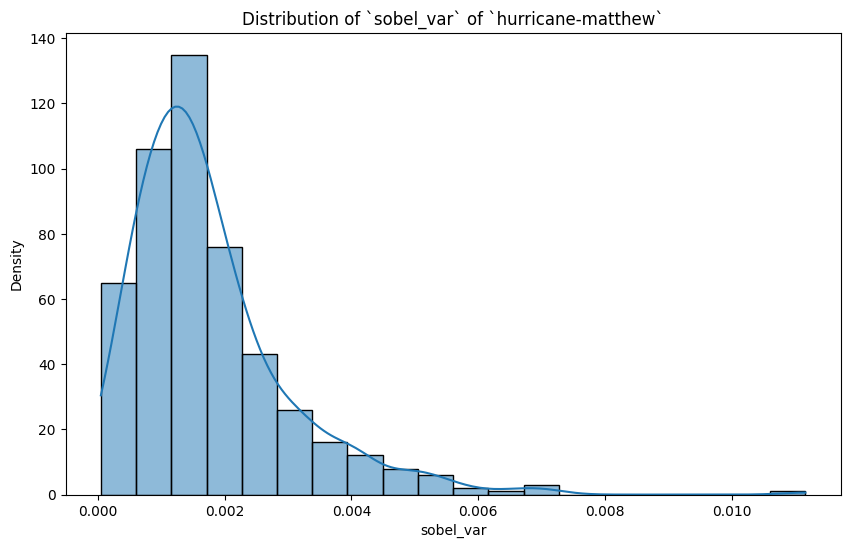

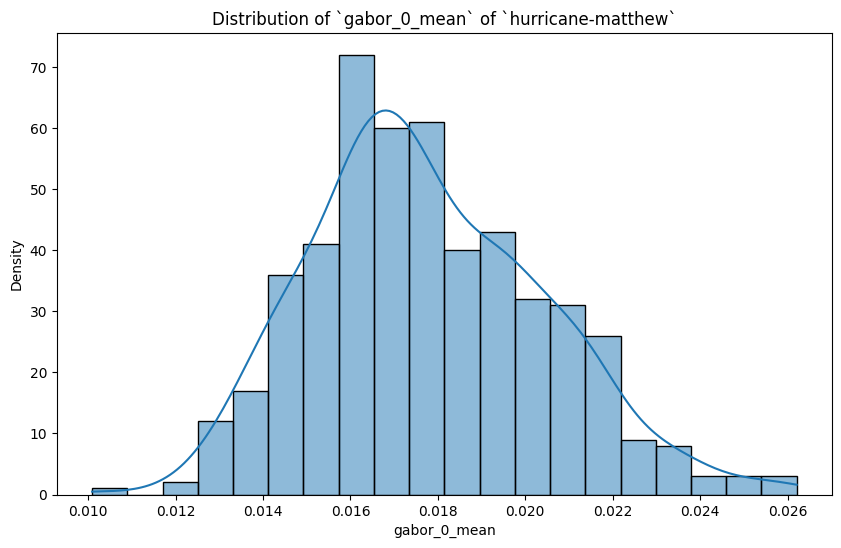

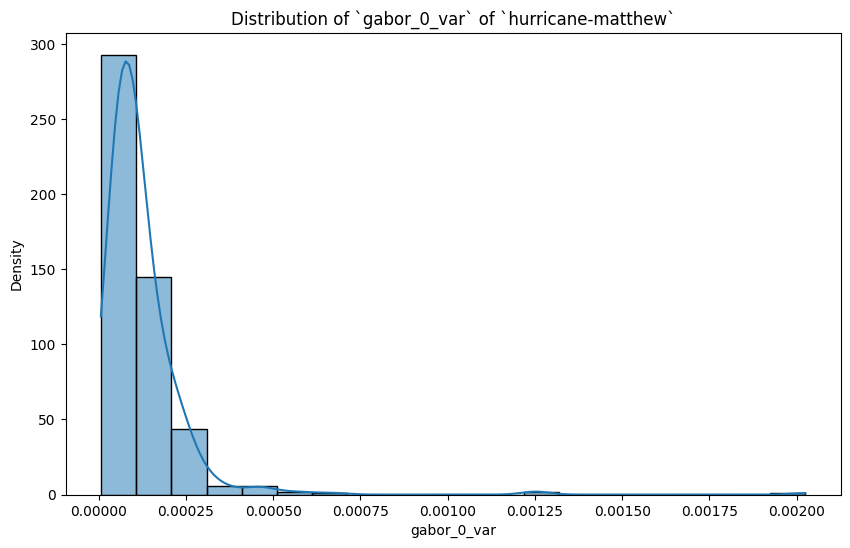

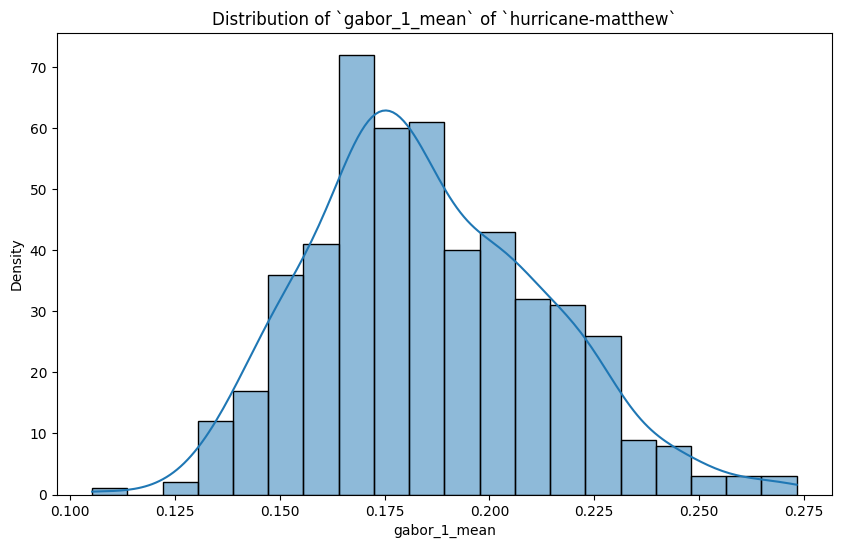

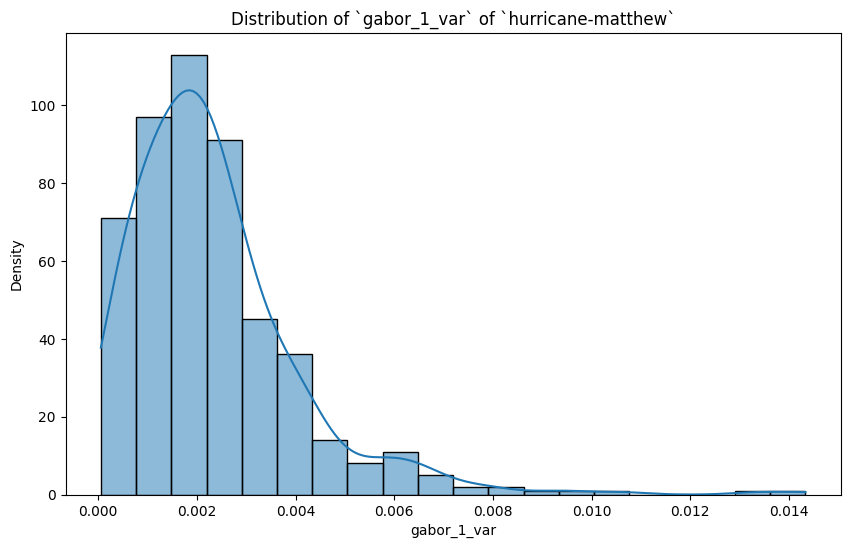

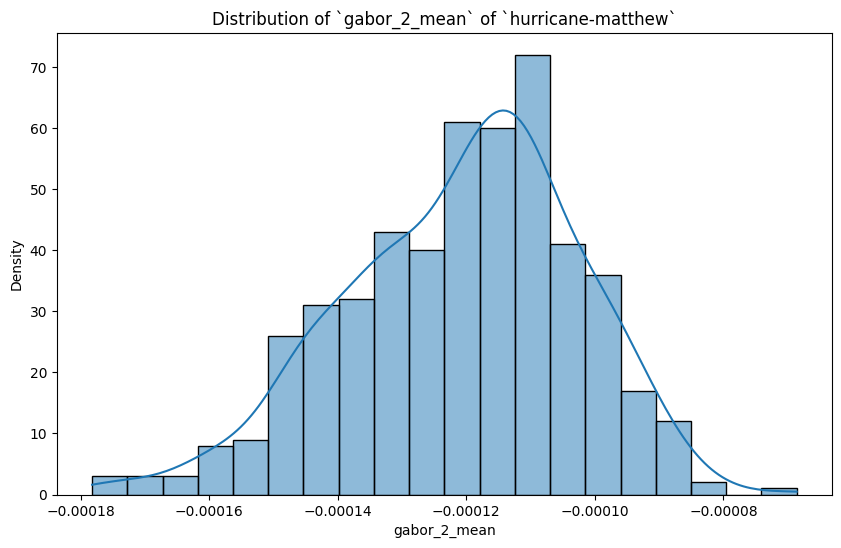

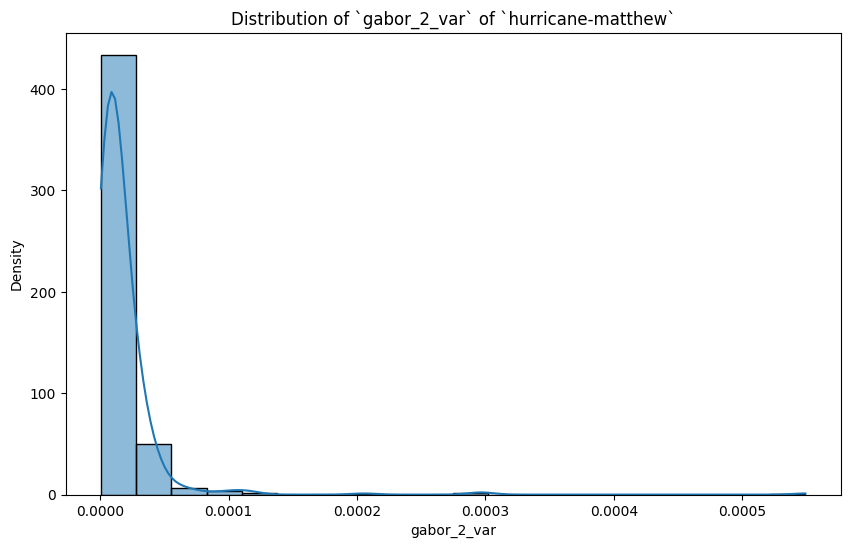

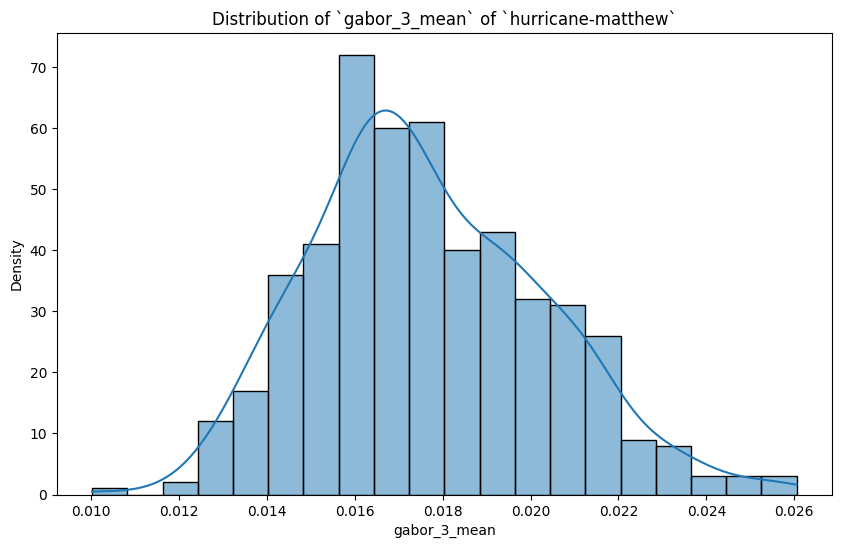

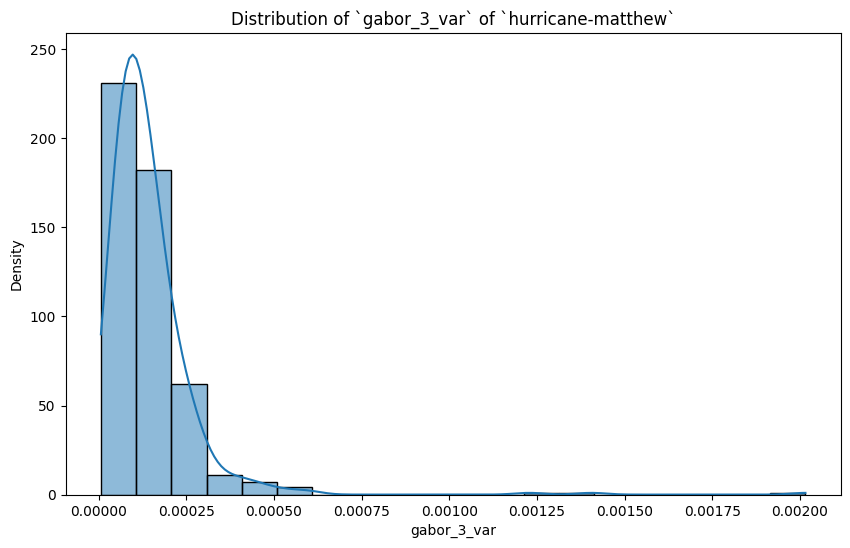

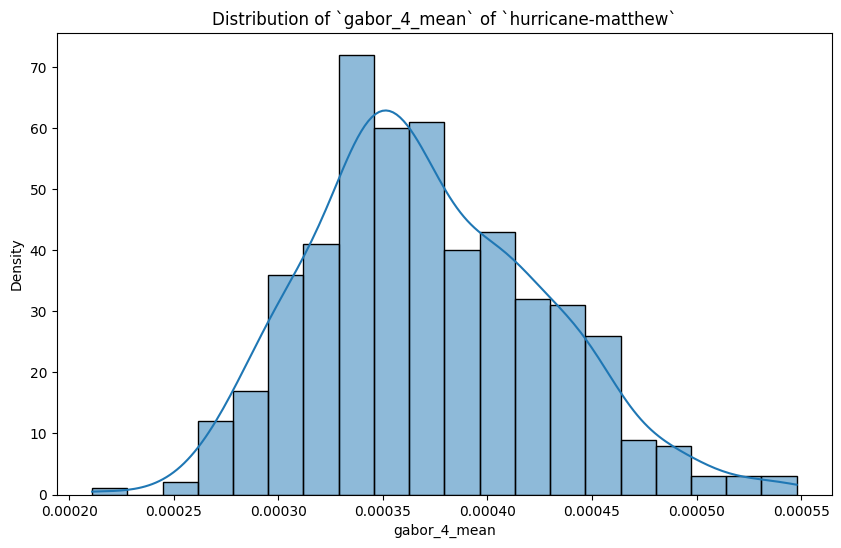

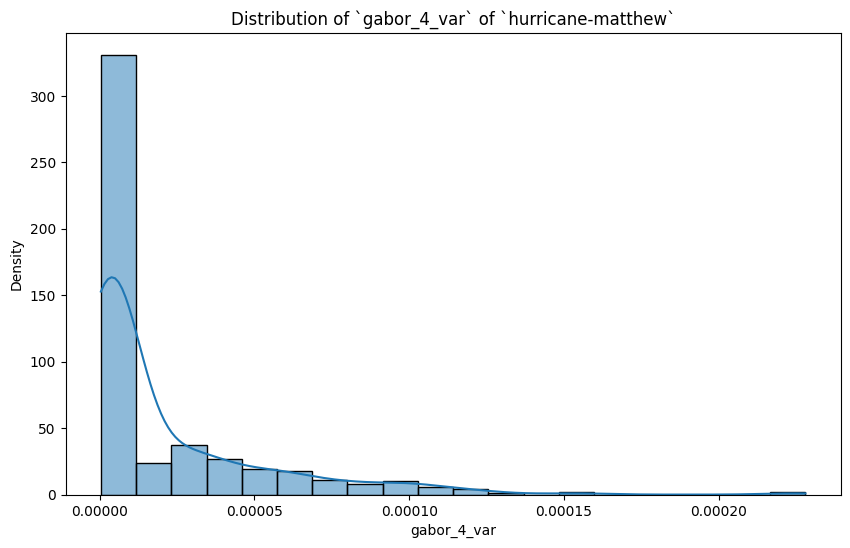

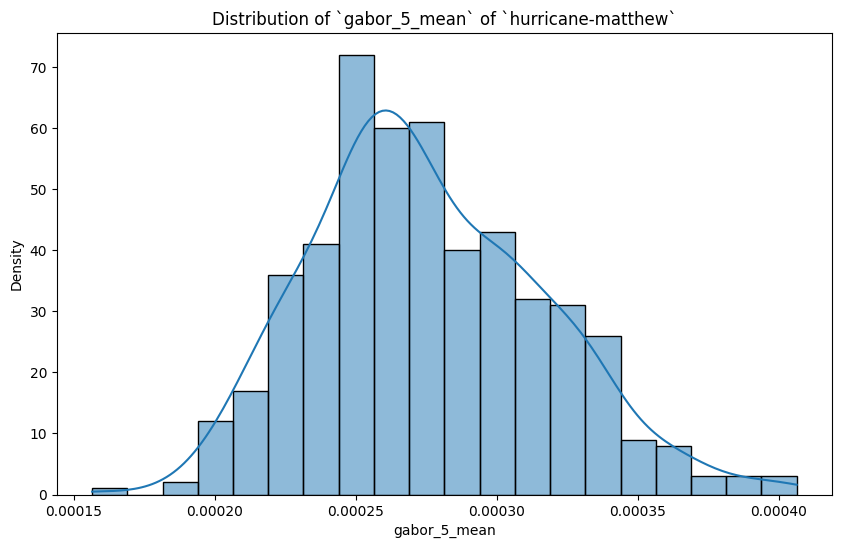

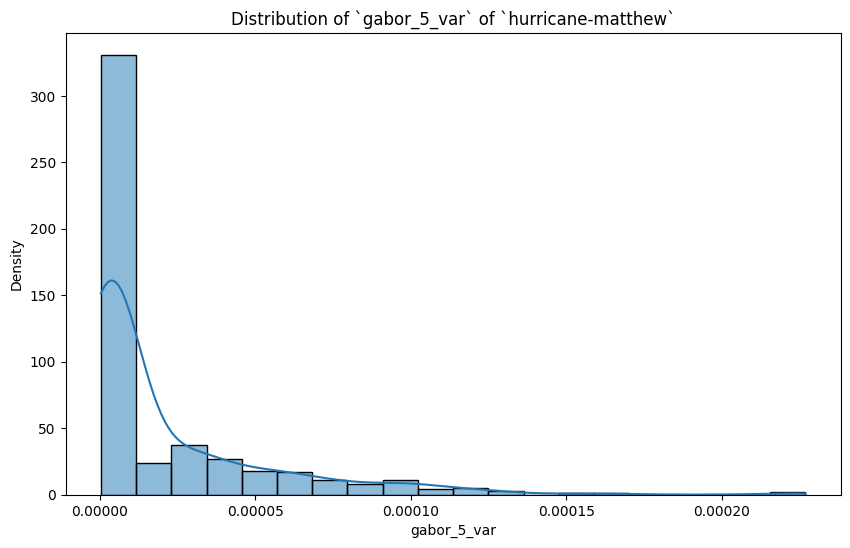

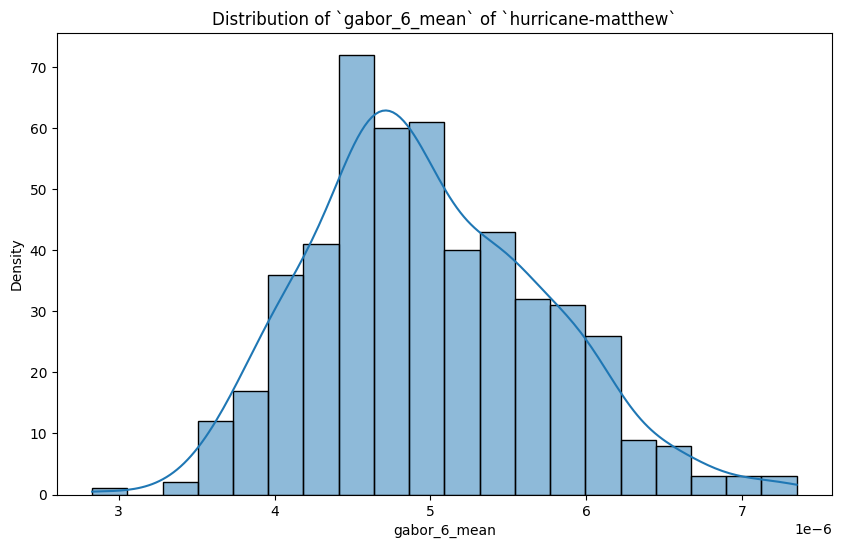

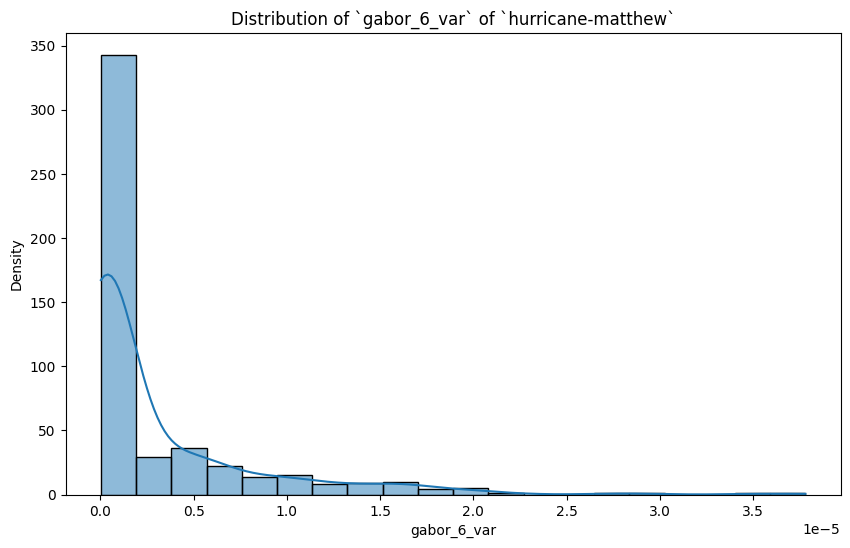

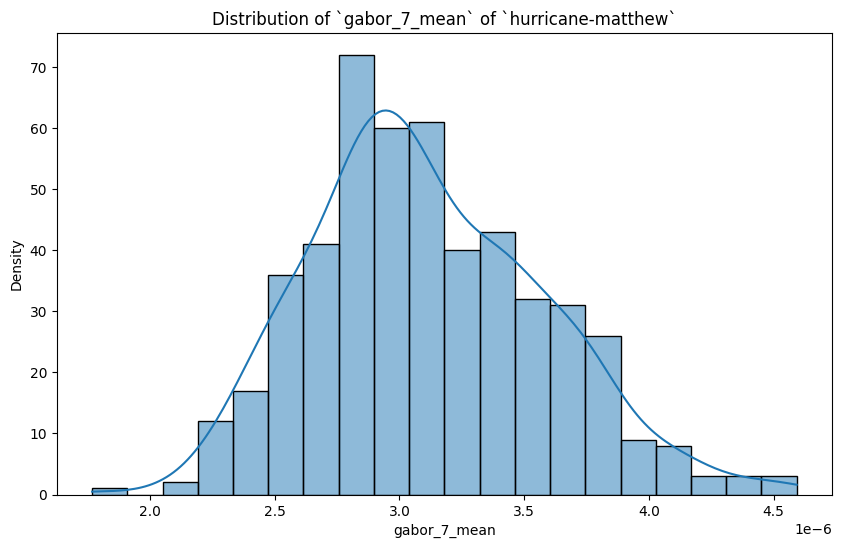

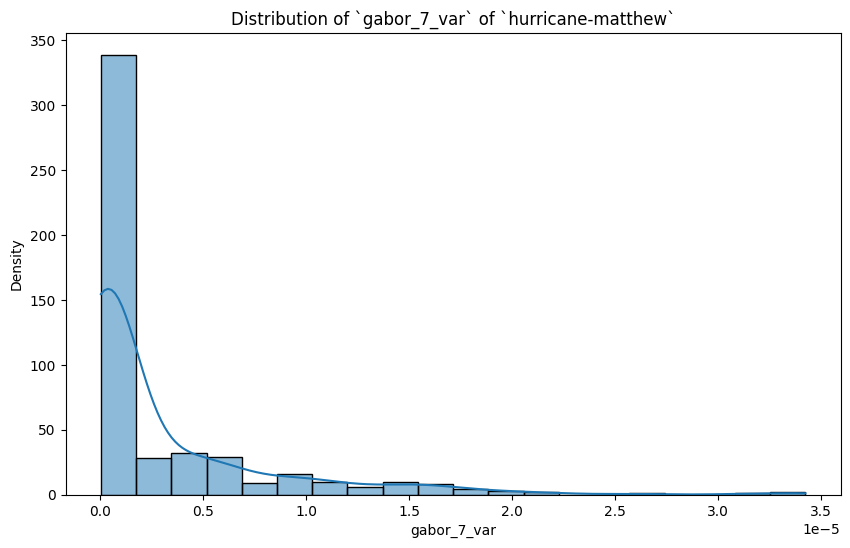

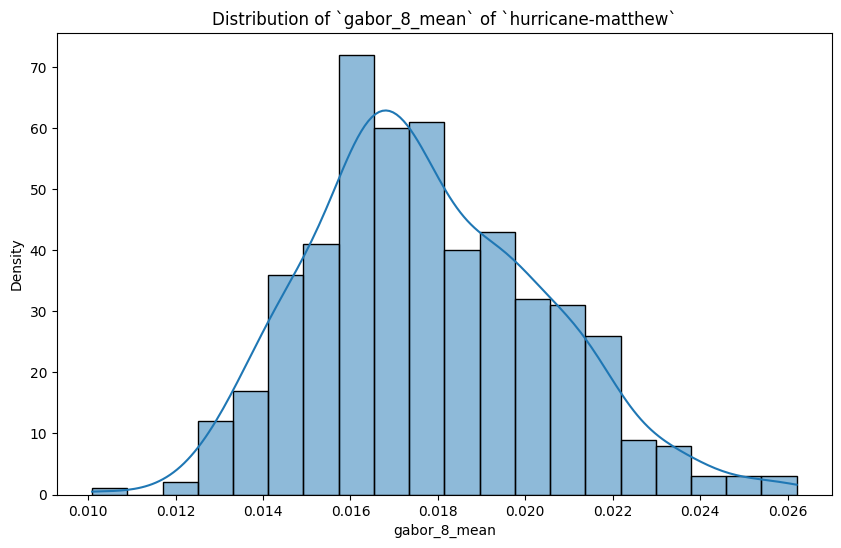

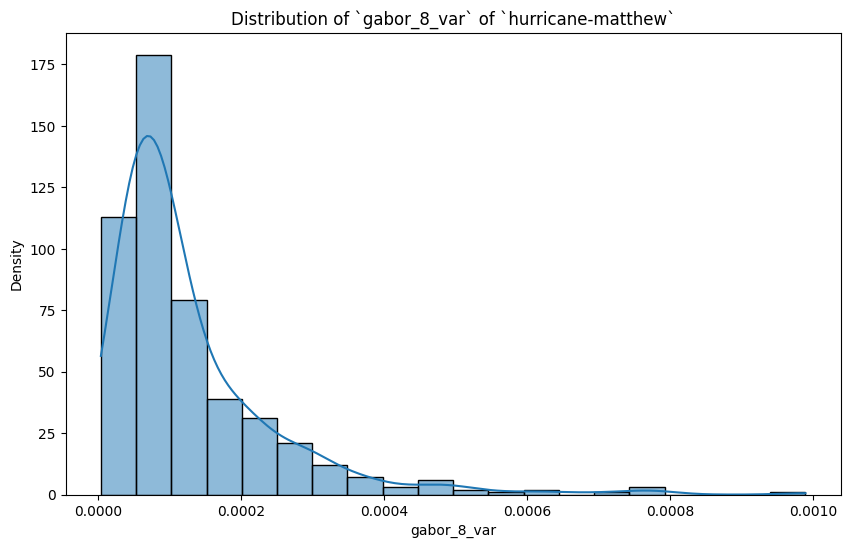

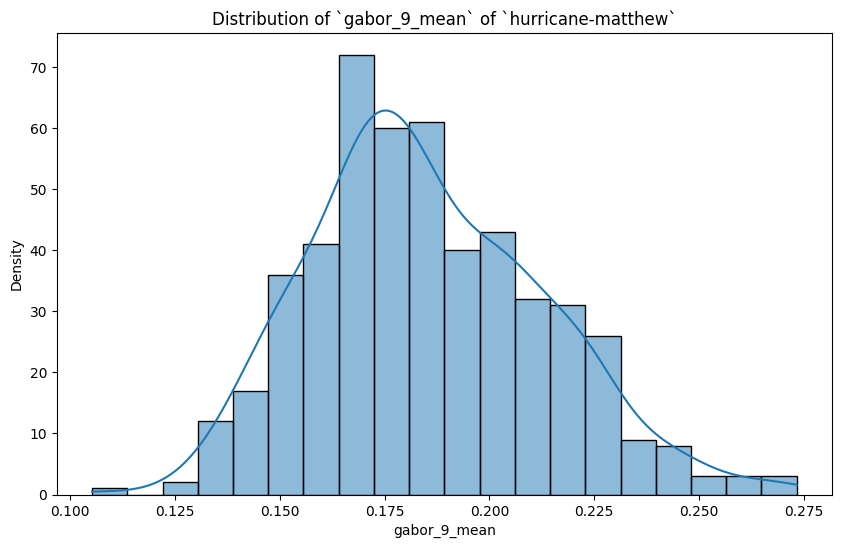

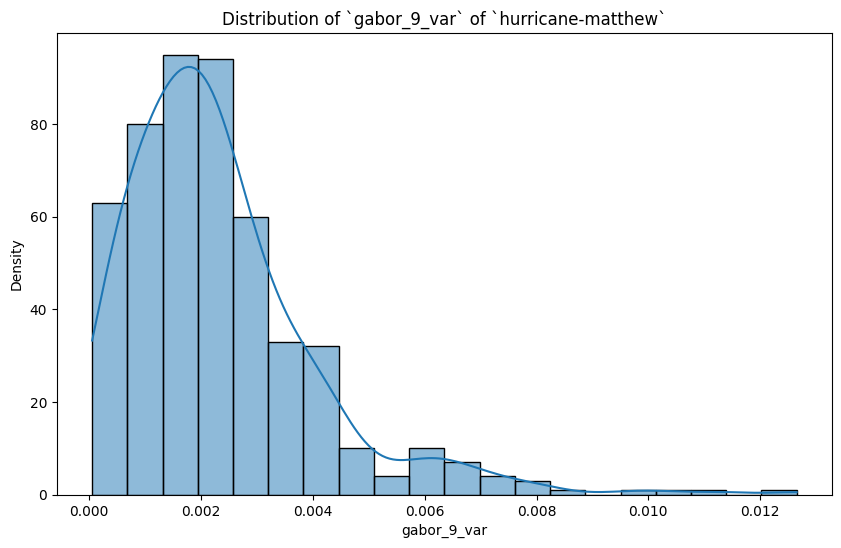

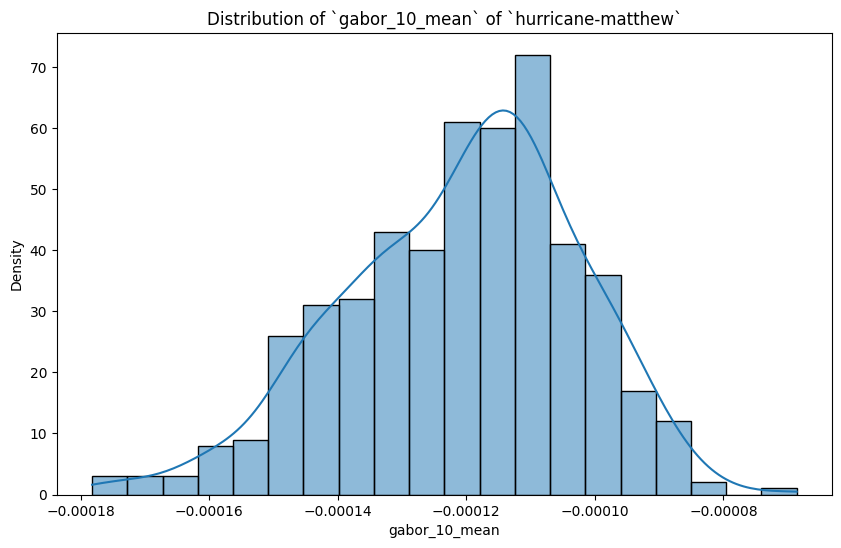

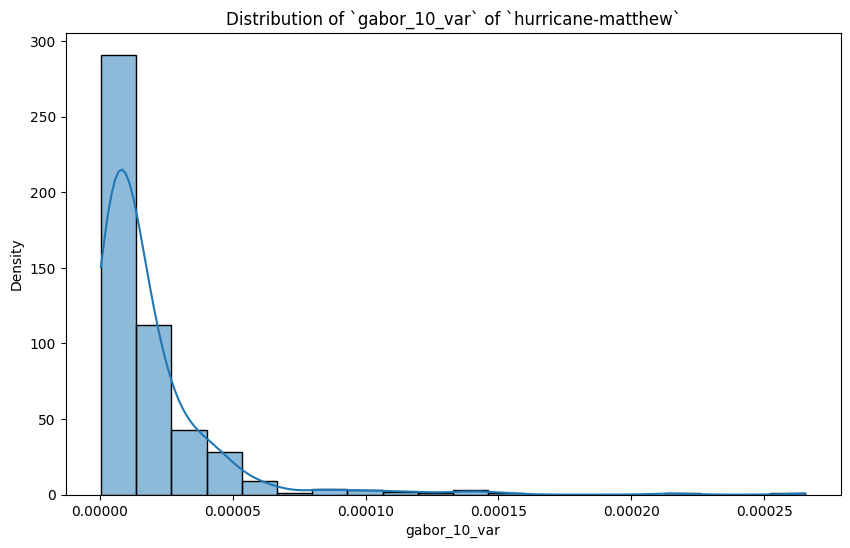

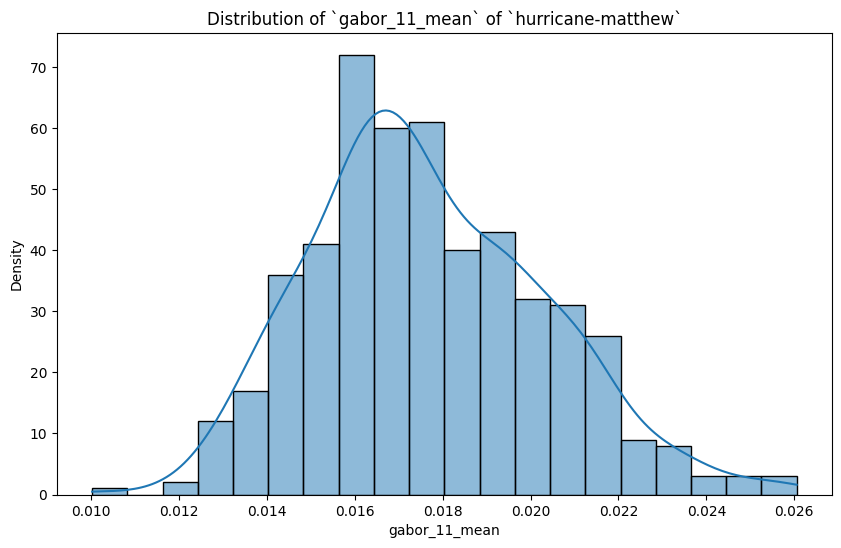

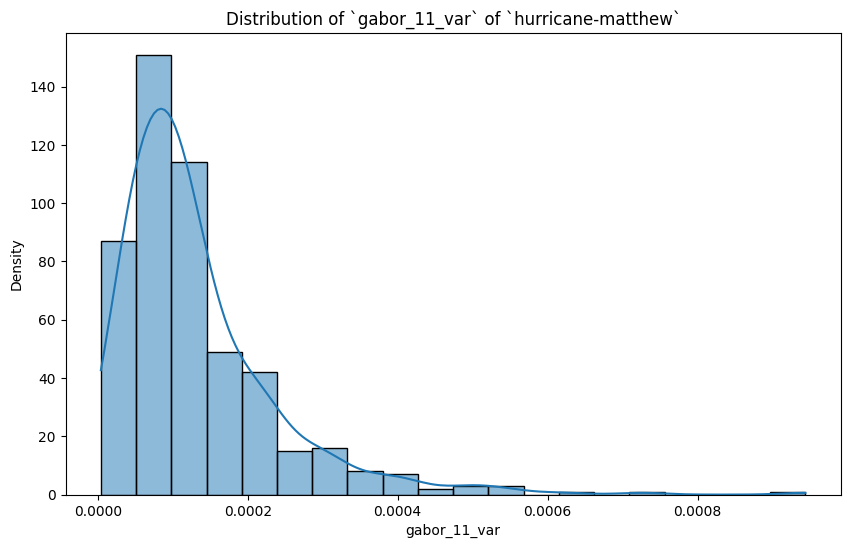

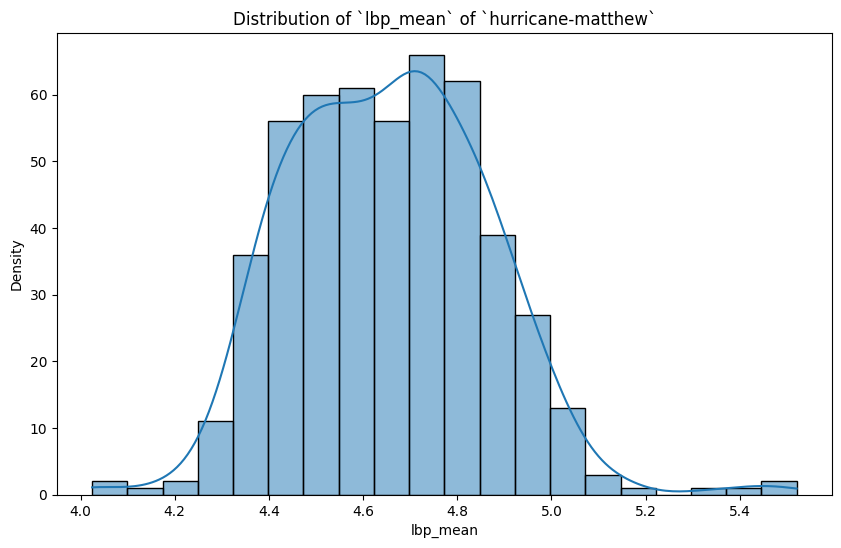

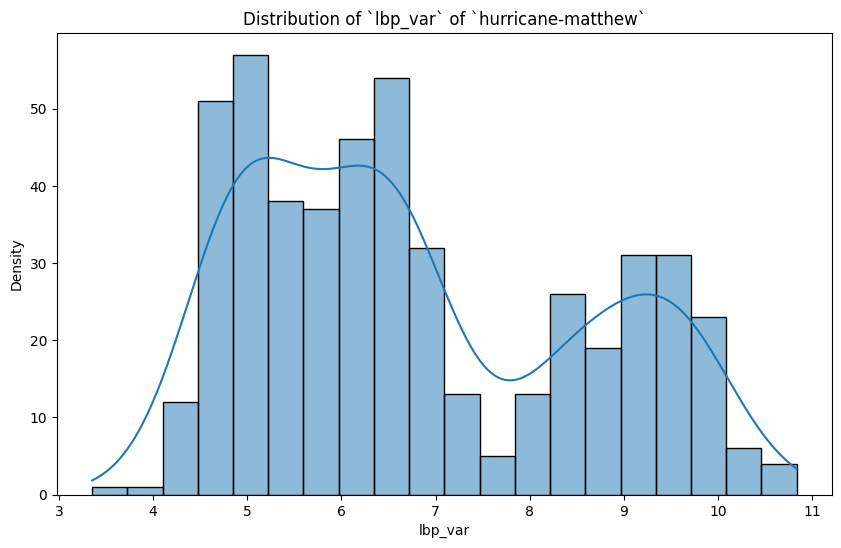

In [8]:
# Define Gabor kernel parameters
theta_vals = [0, np.pi/4, np.pi/2]
sigma_vals = [1, 2]
frequency_vals = [0.6, 0.8]

# Generate Gabor kernels
gabor_kernels = generate_gabor_kernels(theta_vals, sigma_vals, frequency_vals)

# Process each dataset and extract features into a DataFrame
all_datasets_features = {}
for disaster in disaster_list:
    disaster_img_dataset = data[disaster]['images']

    # Take a random sample of the image dataset
    sampled_indices = np.random.choice(range(len(disaster_img_dataset)), size=min(num_samples, len(disaster_img_dataset)), replace=False)
    sampled_images = [disaster_img_dataset[i] for i in sampled_indices]

    image_feature_dicts = [extract_combined_features(img, gabor_kernels) for img in sampled_images]
    all_datasets_features[disaster] = pd.DataFrame(image_feature_dicts)

# Visualize feature distributions for each dataset
for disaster, feature_df in all_datasets_features.items():
    visualize_feature_distribution(feature_df, disaster)

**Compiling all extracted features into a singular DataFrame:**


In [9]:
# Runtime: ~8-9min

# Use the same Gabor kernels from previous cell and extract features from all images

# Dataframe holding feature information for all images across the 3 disasters
feature_df = pd.DataFrame()

# Process each dataset and extract features
for disaster in disaster_list:
    disaster_img_dataset = data[disaster]['images']
    # Placeholder lists for features and labels
    features_list = []
    disasters_list = []
    # Extract features from sampled images
    for img in disaster_img_dataset:
        features = extract_combined_features(img, gabor_kernels)
        features_list.append(features)
    
    # Create a DataFrame with all features and corresponding labels
    features = pd.DataFrame(features_list)
    features['disaster'] = disaster # Add the disaster as a new column
    features['damage_label'] = data[disaster]['labels']
    feature_df = pd.concat([feature_df, features], ignore_index=True)   

display(feature_df)

sobel_mean  sobel_var  gabor_0_mean  gabor_0_var  gabor_1_mean  \
0        0.048752   0.002715      0.021613     0.000109      0.225385   
1        0.046197   0.001996      0.014598     0.000094      0.152225   
2        0.043064   0.002014      0.019877     0.000098      0.207281   
3        0.044347   0.001629      0.018677     0.000089      0.194762   
4        0.037459   0.001431      0.016642     0.000097      0.173548   
...           ...        ...           ...          ...           ...   
26530    0.049909   0.001728      0.017907     0.000102      0.186736   
26531    0.031114   0.001017      0.016687     0.000119      0.174009   
26532    0.071930   0.003764      0.017492     0.000426      0.182411   
26533    0.031701   0.000382      0.012725     0.000053      0.132695   
26534    0.069854   0.007917      0.021001     0.000359      0.219000   

       gabor_1_var  gabor_2_mean  gabor_2_var  gabor_3_mean  gabor_3_var  ...  \
0         0.006954     -0.000147     0.000005      0.021485     0.000144  ...   
1         0.001811     -0.000099     0.000011      0.014511     0.000121  ...   
2         0.004618     -0.000135     0.000007      0.019759     0.000152  ...   
3         0.003269     -0.000127     0.000008      0.018566     0.000125  ...   
4         0.002259     -0.000113     0.000013      0.016544     0.000151  ...   
...            ...           ...          ...           ...          ...  ...   
26530     0.003336     -0.000122     0.000010      0.017801     0.000121  ...   
26531     0.002364     -0.000113     0.000023      0.016588     0.000119  ...   
26532     0.003680     -0.000119     0.000086      0.017389     0.000328  ...   
26533     0.000397     -0.000087     0.000008      0.012649     0.000043  ...   
26534     0.007179     -0.000143     0.000037      0.020876     0.000434  ...   

       gabor_9_mean  gabor_9_var  gabor_10_mean  gabor_10_var  gabor_11_mean  \
0          0.225385     0.007080      -0.000147      0.000010       0.021485   
1          0.152225     0.001832      -0.000099      0.000013       0.014511   
2          0.207281     0.004575      -0.000135      0.000008       0.019759   
3          0.194762     0.003240      -0.000127      0.000013       0.018566   
4          0.173548     0.002111      -0.000113      0.000007       0.016544   
...             ...          ...            ...           ...            ...   
26530      0.186736     0.003429      -0.000122      0.000020       0.017801   
26531      0.174009     0.002191      -0.000113      0.000001       0.016588   
26532      0.182411     0.003326      -0.000119      0.000039       0.017389   
26533      0.132695     0.000394      -0.000087      0.000009       0.012649   
26534      0.219000     0.006719      -0.000143      0.000011       0.020876   

       gabor_11_var  lbp_mean   lbp_var           disaster  damage_label  
0          0.000184  4.652137  4.963108         socal-fire             0  
1          0.000130  4.534314  5.270881         socal-fire             0  
2          0.000121  4.668475  4.821204         socal-fire             0  
3          0.000110  4.610054  4.830619         socal-fire             0  
4          0.000073  4.728526  5.323417         socal-fire             0  
...             ...       ...       ...                ...           ...  
26530      0.000170  4.494991  5.329752  hurricane-matthew             3  
26531      0.000052  4.682500  6.615979  hurricane-matthew             0  
26532      0.000159  4.891156  9.406747  hurricane-matthew             2  
26533      0.000042  4.955435  9.912144  hurricane-matthew             3  
26534      0.000212  4.630405  5.860021  hurricane-matthew             0  

[26535 rows x 30 columns]

**Encoding Task A labels and training a Random Forest Classfier model for feature importance**


In [10]:
# Filter only rows from socal-fire and midwest-flooding
task_A_features = feature_df[(feature_df['disaster'] == 'socal-fire') | (feature_df['disaster'] == 'midwest-flooding')]

# Encode labels to binary format
le = LabelEncoder()
binary_labels = le.fit_transform(task_A_features['disaster'])  # Converts 'socal-fire' to 0 and 'midwest-flooding' to 1

# Normalize the features
scaler = StandardScaler()
scaled_A = scaler.fit_transform(task_A_features.iloc[:,:-2]) # -2 to exclude the disaster and damage_label

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_A, binary_labels, test_size=0.2, random_state=42)

Accuracy: 0.9827754306142347
                  precision    recall  f1-score   support

midwest-flooding      0.984     0.978     0.981      1404
      socal-fire      0.982     0.987     0.984      1673

        accuracy                          0.983      3077
       macro avg      0.983     0.982     0.983      3077
    weighted avg      0.983     0.983     0.983      3077



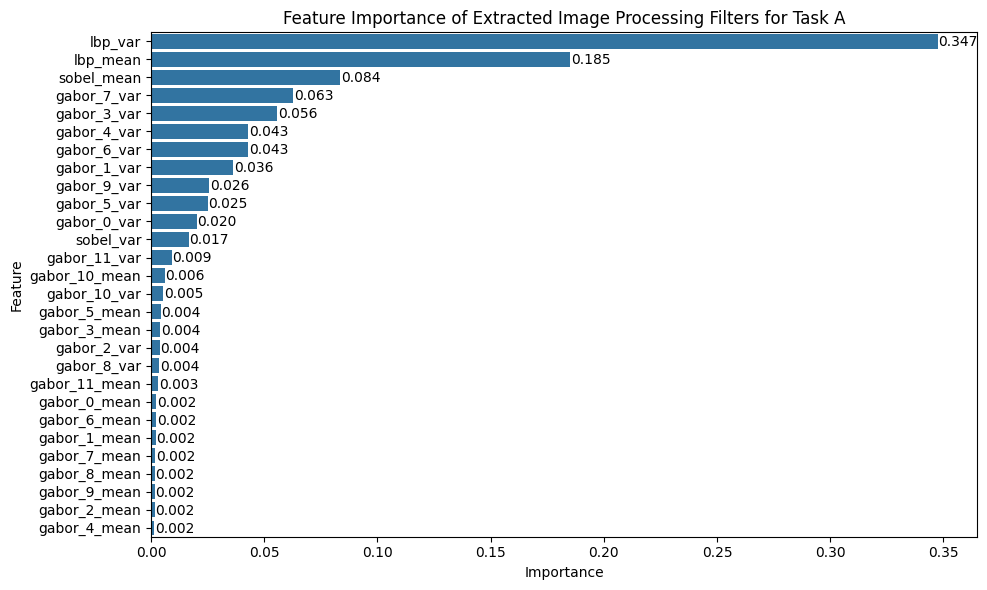

In [11]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': task_A_features.columns[:-2],
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.675))
plt.title('Feature Importance of Extracted Image Processing Filters for Task A')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Save important features with an importance greater than 0.02 to add to Task A dataframe
important_features_A = feature_importances[feature_importances['importance'] > 0.05]['feature'].to_list()

In [12]:
# Filter only rows from hurricane-matthew
task_B_features = feature_df[feature_df['disaster'] == 'hurricane-matthew'].reset_index().drop(columns='index')

# No need to encode, already categorized from 0 to 3
damage_labels = task_B_features['damage_label']

# Normalize the features
scaler = StandardScaler()
scaled_B = scaler.fit_transform(task_B_features.iloc[:,:-2])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_B, damage_labels, test_size=0.2, random_state=42)


Accuracy: 0.604661586732407
              precision    recall  f1-score   support

           0      0.562     0.450     0.500       493
           1      0.623     0.811     0.705      1046
           2      0.375     0.083     0.135       327
           3      0.625     0.690     0.656       365

    accuracy                          0.605      2231
   macro avg      0.546     0.508     0.499      2231
weighted avg      0.574     0.605     0.568      2231



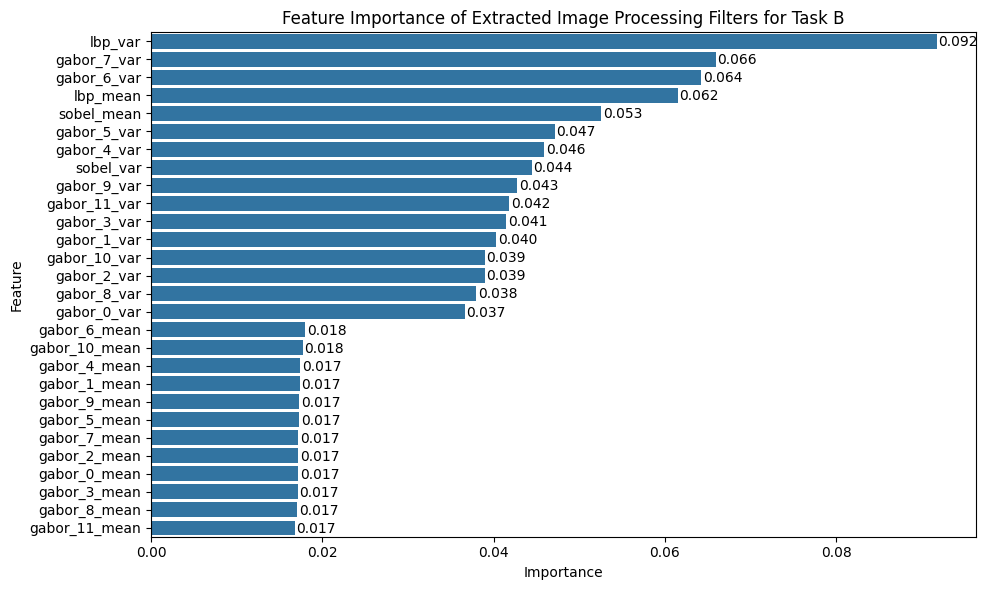

In [13]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Define numeric damage labels as strings for classification report
dmg_labels = ['0', '1', '2', '3']

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels, digits=3))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': task_B_features.columns[:-2],
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.675))
plt.title('Feature Importance of Extracted Image Processing Filters for Task B')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Save important features with an importance greater than 0.02 to add to Task B dataframe
important_features_B = feature_importances[feature_importances['importance'] > 0.02]['feature'].to_list()

**Initializing a dictionary containing each disaster's dataframe, containing features that may be relevant in the downstream training of our model:**


In [64]:
df = {}
for disaster in disaster_list:
  df[disaster] = pd.DataFrame(pd.Series(data[disaster]['images'])).rename({0:'image_matrix'}, axis=1)
  df[disaster]['disaster'] = f'{disaster}'
  df[disaster]['label'] = pd.Series(data[disaster]['labels'])
  df[disaster]['height'] = pd.Series(heights[disaster])
  df[disaster]['width'] = pd.Series(widths[disaster])
  df[disaster]['aspect_ratio'] = df[disaster]['width'] / df[disaster]['height']
  df[disaster]['total_pixels'] = df[disaster]['height'] * df[disaster]['width']
  df[disaster]['avg_pixel_int'] = df[disaster]['image_matrix'].apply(np.mean)
  df[disaster]['avg_red_pixel_int'] = df[disaster]['image_matrix'].apply(lambda x: np.mean(x[:,:,0]))
  df[disaster]['avg_green_pixel_int'] = df[disaster]['image_matrix'].apply(lambda x: np.mean(x[:,:,1]))
  df[disaster]['avg_blue_pixel_int'] = df[disaster]['image_matrix'].apply(lambda x: np.mean(x[:,:,2]))

**Assigning each dataframe to their respective tasks and exporting them as '.csv' files for easier importing later on:**


In [65]:
task_A_df = pd.concat([df['socal-fire'], df['midwest-flooding']], ignore_index=True)
for feature in important_features_A:
  task_A_df[feature] = task_A_features[feature]

assert(task_A_df.shape[0] == 8380+7004)
print('Top 3 rows from task_A_df')
display(task_A_df.head(3))
print(f"Task A shape: {task_A_df.shape}")

task_B_df = df['hurricane-matthew']
for feature in important_features_B:
  task_B_df[feature] = task_B_features[feature]

assert(task_B_df.shape[0] == 11151)
print('\nTop 3 rows from task_B_df')
display(task_B_df.head(3))

Top 3 rows from task_A_df


image_matrix    disaster  label  \
0  [[[50, 72, 48], [49, 71, 47], [49, 71, 48], [4...  socal-fire      0   
1  [[[66, 84, 80], [79, 99, 94], [103, 127, 120],...  socal-fire      0   
2  [[[74, 107, 95], [74, 106, 95], [70, 100, 91],...  socal-fire      0   

   height  width  aspect_ratio  total_pixels  avg_pixel_int  \
0     144    195      1.354167         28080     122.675415   
1      48     51      1.062500          2448      82.526416   
2     104    140      1.346154         14560     110.527908   

   avg_red_pixel_int  avg_green_pixel_int  avg_blue_pixel_int   lbp_var  \
0         110.409046           131.513390          126.103811  4.963108   
1          70.399918            89.844771           87.334559  5.270881   
2          97.319162           122.642376          111.622184  4.821204   

   lbp_mean  sobel_mean   gabor_7_var  gabor_3_var  
0  4.652137    0.048752  3.979585e-07     0.000144  
1  4.534314    0.046197  4.679938e-07     0.000121  
2  4.668475    0.043064  2.617666e-07     0.000152

Task A shape: (15384, 16)

Top 3 rows from task_B_df


image_matrix           disaster  \
0  [[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...  hurricane-matthew   
1  [[[150, 177, 183], [147, 174, 182], [153, 180,...  hurricane-matthew   
2  [[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...  hurricane-matthew   

   label  height  width  aspect_ratio  total_pixels  avg_pixel_int  \
0      3      65     54      0.830769          3510      94.020703   
1      0      67    105      1.567164          7035     106.040938   
2      1      54     56      1.037037          3024     117.725198   

   avg_red_pixel_int  avg_green_pixel_int  ...  gabor_4_var  sobel_var  \
0          75.702279           105.275783  ...     0.000092   0.002927   
1          88.451599           119.422886  ...     0.000003   0.001346   
2         111.971561           122.160714  ...     0.000172   0.003301   

   gabor_9_var  gabor_11_var  gabor_3_var  gabor_1_var  gabor_10_var  \
0     0.001371      0.000122     0.000132     0.001399      0.000019   
1     0.003632      0.000073     0.000179     0.003852      0.000005   
2     0.005691      0.000342     0.000296     0.005609      0.000076   

   gabor_2_var  gabor_8_var  gabor_0_var  
0     0.000016     0.000184     0.000149  
1     0.000029     0.000064     0.000160  
2     0.000061     0.000447     0.000344  

[3 rows x 27 columns]

**Verifying that our dataframes don't have any `NaN` values:**


In [66]:
assert(task_A_df.isna().any().all() == False)
assert(task_B_df.isna().any().all() == False)

**Looking at one `hurricane-matthew` image under different color channels and filters:**


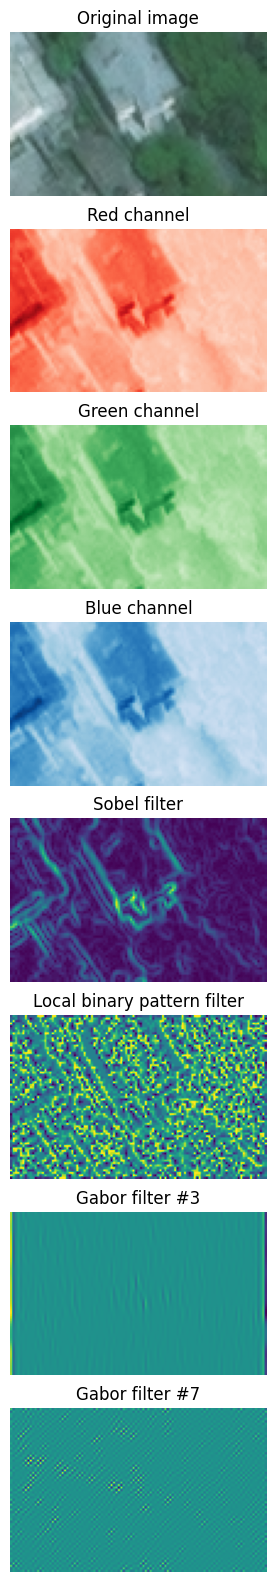

In [67]:
plt.figure(figsize=(20,20))

plt.subplot(8, 1, 1)
plt.imshow(task_B_df['image_matrix'][1])
plt.title("Original image")
plt.axis("off")

plt.subplot(8, 1, 2)
plt.imshow(task_B_df['image_matrix'][1][:,:,0], cmap="Reds", vmin=0, vmax=255)
plt.title("Red channel")
plt.axis("off")

plt.subplot(8, 1, 3)
plt.imshow(task_B_df['image_matrix'][1][:,:,1], cmap="Greens", vmin=0, vmax=255)
plt.title("Green channel")
plt.axis("off")

plt.subplot(8, 1, 4)
plt.imshow(task_B_df['image_matrix'][1][:,:,2], cmap="Blues", vmin=0, vmax=255)
plt.title("Blue channel")
plt.axis("off")

plt.subplot(8, 1, 5)
plt.imshow(get_sobel_features(task_B_df['image_matrix'][1]))
plt.title("Sobel filter")
plt.axis("off")

plt.subplot(8, 1, 6)
plt.imshow(get_local_binary_pattern(task_B_df['image_matrix'][1]))
plt.title("Local binary pattern filter")
plt.axis("off")

plt.subplot(8, 1, 7)
plt.imshow(get_gabor_features(task_B_df['image_matrix'][1], gabor_kernels[2]))
plt.title("Gabor filter #3")
plt.axis("off")

plt.subplot(8, 1, 8)
plt.imshow(get_gabor_features(task_B_df['image_matrix'][1], gabor_kernels[6]))
plt.title("Gabor filter #7")
plt.axis("off")

plt.show()

**Exploring each dataframe through `.groupby()` operations to find potential features of interest:**

From the first 'groupby' operation, we can see that the `socal-fire` images have, on average, higher total pixels and pixel intensities than the `midwest-flooding` images. This corroborates the conclusion drawn from the color channel intensity histograms, which showed that the mean intensities of pixels across all three channels were higher, which may be something to consider when training our first model.

The `hurricane-matthew` dataframe has less obvious features to draw from, besides mean total pixels. Thankfully, we have extracted many features from the image processing step to train our model on.


In [68]:
print("Grouping task_A_df by disaster:")
by_disaster = task_A_df.groupby('disaster').mean(numeric_only=True).drop('label', axis=1)
display(by_disaster)

print("\nGrouping task_B_df by label:")
by_label = task_B_df.groupby('label').mean(numeric_only=True)
display(by_label)

Grouping task_A_df by disaster:


height       width  aspect_ratio  total_pixels  \
disaster                                                              
midwest-flooding  82.353798   84.223587      1.185343   8552.915762   
socal-fire        99.801074  101.391527      1.153420  12742.040215   

                  avg_pixel_int  avg_red_pixel_int  avg_green_pixel_int  \
disaster                                                                  
midwest-flooding      84.703778          70.854311            96.698330   
socal-fire           102.577726          89.820434           110.895464   

                  avg_blue_pixel_int   lbp_var  lbp_mean  sobel_mean  \
disaster                                                               
midwest-flooding           86.558693  7.838181  4.961290    0.030281   
socal-fire                107.017282  5.202468  4.634897    0.045409   

                   gabor_7_var  gabor_3_var  
disaster                                     
midwest-flooding  3.334399e-06     0.000099  
socal-fire        4.024466e-07     0.000172


Grouping task_B_df by label:


height      width  aspect_ratio  total_pixels  avg_pixel_int  \
label                                                                    
0      59.269479  59.700494      1.112572   4313.262258      98.637923   
1      64.870894  66.505348      1.098256   5234.814171     101.180972   
2      63.480570  64.694948      1.116007   4779.865285     100.494853   
3      43.938506  46.233908      1.096346   2279.792529      96.365045   

       avg_red_pixel_int  avg_green_pixel_int  avg_blue_pixel_int   lbp_var  \
label                                                                         
0              83.022100           111.657829          101.233840  7.106449   
1              87.121299           111.486391          104.935227  6.090460   
2              87.485277           110.332131          103.667150  6.587972   
3              81.014538           108.541397           99.539201  8.467744   

       gabor_7_var  ...  gabor_4_var  sobel_var  gabor_9_var  gabor_11_var  \
label               ...                                                      
0         0.000002  ...     0.000018   0.001632     0.002258      0.000125   
1         0.000001  ...     0.000010   0.001700     0.002413      0.000134   
2         0.000004  ...     0.000026   0.002087     0.002576      0.000154   
3         0.000009  ...     0.000059   0.001919     0.001785      0.000135   

       gabor_3_var  gabor_1_var  gabor_10_var  gabor_2_var  gabor_8_var  \
label                                                                     
0         0.000120     0.002244      0.000020     0.000014     0.000132   
1         0.000135     0.002411      0.000016     0.000014     0.000110   
2         0.000167     0.002588      0.000020     0.000017     0.000145   
3         0.000144     0.001794      0.000027     0.000022     0.000174   

       gabor_0_var  
label               
0         0.000106  
1         0.000108  
2         0.000137  
3         0.000153  

[4 rows x 24 columns]

**Plotting data from the `.groupby()` operations:**


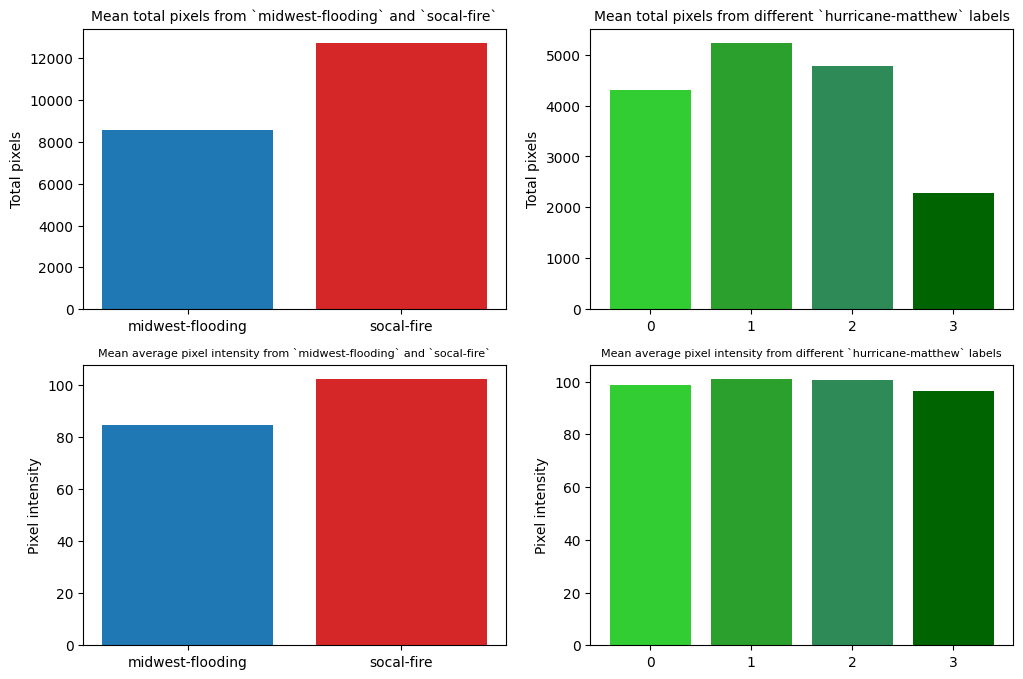

In [69]:
fig, axs = plt.subplots(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(x=by_disaster.index,
        height=by_disaster['total_pixels'],
        color=['tab:blue','tab:red'])
plt.ylabel("Total pixels")
plt.title("Mean total pixels from `midwest-flooding` and `socal-fire`", fontsize=10)

plt.subplot(2, 2, 2)
plt.bar(x=by_label.index.astype('str'),
        height=by_label['total_pixels'],
        color=['limegreen', 'tab:green', 'seagreen', 'darkgreen'])
plt.ylabel("Total pixels")
plt.title("Mean total pixels from different `hurricane-matthew` labels", fontsize=10)

plt.subplot(2, 2, 3)
plt.bar(x=by_disaster.index,
        height=by_disaster['avg_pixel_int'],
        color=['tab:blue','tab:red'])
plt.ylabel("Pixel intensity")
plt.title("Mean average pixel intensity from `midwest-flooding` and `socal-fire`", fontsize=8)

plt.subplot(2, 2, 4)
plt.bar(x=by_label.index.astype('str'),
        height=by_label['avg_pixel_int'],
        color=['limegreen', 'tab:green', 'seagreen', 'darkgreen'])
plt.ylabel("Pixel intensity")
plt.title("Mean average pixel intensity from different `hurricane-matthew` labels", fontsize=8)

plt.show()

**Defining a function to calculate the percent coverage of pixels that cross a certain intensity threshold:**


In [70]:
def color_coverage(image, area, thresholds):
  """
  This function finds the percent coverage of pixels that reach a defined threshold
  of intensity for a given color channel.

  Args:
        image (ndarray): Numpy array representation of an image.
        area (int): Total pixel area of an image.
        rgb (int): Integer representing the color channel (0 for red, 1 for green, 2 for blue).
        threshold (float): The threshold intensity of pixels.

    Returns:
        percent_color (float): The percentage of pixels in an image that cross the threshold intensity.
  """
  colors_dict = {0:'red', 1:'green', 2:'blue'}
  percent_colors = []
  for rgb, threshold in enumerate(thresholds):
    pixel_count = (image['image_matrix'][:,:,rgb] >= threshold).sum()
    percent_color = pixel_count / area
    percent_colors.append((colors_dict[rgb], percent_color))
  return percent_colors

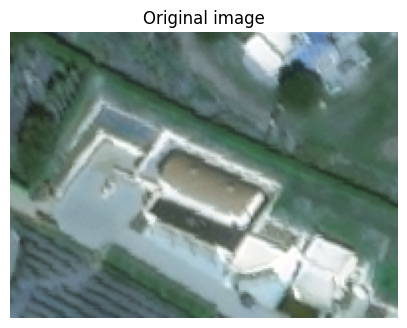

About 64.0% of red pixels met the threshold in the above image.
About 67.60000000000001% of green pixels met the threshold in the above image.
About 64.3% of blue pixels met the threshold in the above image.


In [71]:
thresholds_A = [int(round(np.mean(by_disaster[column]), 0)) for column in by_disaster.iloc[:, 5:8].columns]

plt.figure(figsize=(5,5))

plt.imshow(task_A_df['image_matrix'][0])
plt.title("Original image")
plt.axis("off")
plt.show()

#select image matrix & area
fire_img = task_A_df.iloc[0]
fire_img_size = task_A_df['total_pixels'][0]

percents = color_coverage(fire_img,fire_img_size,thresholds_A)
for percent in percents:
  print(f'About {percent[1].round(3)*100}% of {percent[0]} pixels met the threshold in the above image.')

**Appending a new feature to the Task 1 dataframe using the `color_coverage()` function:**


In [72]:
thresholds_B = [int(round(np.mean(by_label[column]), 0)) for column in by_label.iloc[:, 5:8].columns]

def color_coverage_column(row, thresholds):
    coverage = color_coverage(row, row['total_pixels'], thresholds)
    for i, (color, percent_coverage) in enumerate(coverage):
        col_name = f'area of {color} pixels above {thresholds[i]}'
        row[col_name] = percent_coverage
    return row

task_A_df = task_A_df.apply(lambda x: color_coverage_column(x, thresholds_A),axis=1)
task_B_df = task_B_df.apply(lambda x: color_coverage_column(x, thresholds_B),axis=1)

print('Top 3 rows from task_A_df:')
display(task_A_df.head(3))

print('Top 3 rows from task_B_df:')
display(task_B_df.head(3))

Top 3 rows from task_A_df:


image_matrix    disaster  label  \
0  [[[50, 72, 48], [49, 71, 47], [49, 71, 48], [4...  socal-fire      0   
1  [[[66, 84, 80], [79, 99, 94], [103, 127, 120],...  socal-fire      0   
2  [[[74, 107, 95], [74, 106, 95], [70, 100, 91],...  socal-fire      0   

   height  width  aspect_ratio  total_pixels  avg_pixel_int  \
0     144    195      1.354167         28080     122.675415   
1      48     51      1.062500          2448      82.526416   
2     104    140      1.346154         14560     110.527908   

   avg_red_pixel_int  avg_green_pixel_int  avg_blue_pixel_int   lbp_var  \
0         110.409046           131.513390          126.103811  4.963108   
1          70.399918            89.844771           87.334559  5.270881   
2          97.319162           122.642376          111.622184  4.821204   

   lbp_mean  sobel_mean   gabor_7_var  gabor_3_var  \
0  4.652137    0.048752  3.979585e-07     0.000144   
1  4.534314    0.046197  4.679938e-07     0.000121   
2  4.668475    0.043064  2.617666e-07     0.000152   

   area of red pixels above 80  area of green pixels above 104  \
0                     0.639957                        0.676389   
1                     0.213644                        0.223039   
2                     0.551236                        0.649313   

   area of blue pixels above 97  
0                      0.643020  
1                      0.269608  
2                      0.546978

Top 3 rows from task_B_df:


image_matrix           disaster  \
0  [[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...  hurricane-matthew   
1  [[[150, 177, 183], [147, 174, 182], [153, 180,...  hurricane-matthew   
2  [[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...  hurricane-matthew   

   label  height  width  aspect_ratio  total_pixels  avg_pixel_int  \
0      3      65     54      0.830769          3510      94.020703   
1      0      67    105      1.567164          7035     106.040938   
2      1      54     56      1.037037          3024     117.725198   

   avg_red_pixel_int  avg_green_pixel_int  ...  gabor_11_var  gabor_3_var  \
0          75.702279           105.275783  ...      0.000122     0.000132   
1          88.451599           119.422886  ...      0.000073     0.000179   
2         111.971561           122.160714  ...      0.000342     0.000296   

   gabor_1_var  gabor_10_var  gabor_2_var  gabor_8_var  gabor_0_var  \
0     0.001399      0.000019     0.000016     0.000184     0.000149   
1     0.003852      0.000005     0.000029     0.000064     0.000160   
2     0.005609      0.000076     0.000061     0.000447     0.000344   

   area of red pixels above 85  area of green pixels above 111  \
0                     0.226211                        0.290028   
1                     0.426866                        0.460270   
2                     0.635251                        0.510913   

   area of blue pixels above 102  
0                       0.403419  
1                       0.462118  
2                       0.601852  

[3 rows x 30 columns]

**Plotting the difference in percent coverage of `socal-fire` images by the different labels:**


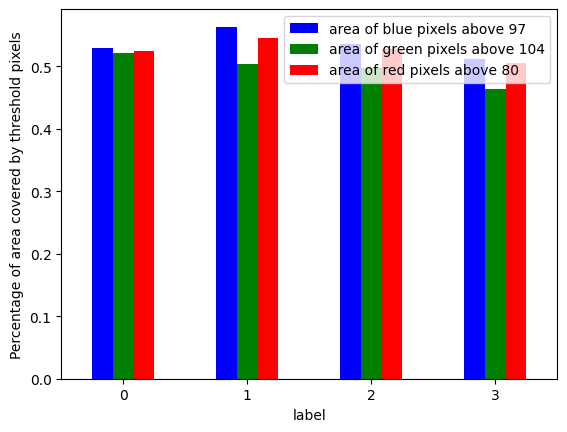

In [73]:
#selects only fires
fires = task_A_df[task_A_df['disaster'] == 'socal-fire']
#labels & color fractions
fires_colors = fires.iloc[:,[2,-1,-2,-3]]

#groupby label and calculate mean
fires_grouped = fires_colors.groupby('label').agg('mean')

fires_grouped.plot(kind='bar',rot='horizontal',ylabel='Percentage of area covered by threshold pixels', color=['b','g','r'])

plt.legend()

plt.show()

**Saving task dataframes as a `.csv` files for easier importing later on:**


In [74]:
task_A_df.to_csv('../data/task-data/task-A.csv', index=False)
task_B_df.to_csv('../data/task-data/task-B.csv', index=False)